# This is the Saildrone and MUR global 1 km sea surface temperature collocation code. 


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xarray as xr

def get_sat_filename(date):
    dir_sat='F:/data/sst/jpl_mur/v4.1/'
    syr, smon, sdym, sjdy = str(date.dt.year.data), str(date.dt.month.data).zfill(2), str(date.dt.day.data).zfill(2), str(date.dt.dayofyear.data).zfill(2)
    sat_filename = dir_sat + syr + '/'+ sjdy + '/' + syr + smon + sdym + '090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc'
    exists = os.path.isfile(sat_filename)
    return sat_filename, exists

def robust_std(ds):
    MAD = np.nanmedian(ds)
    std_robust = MAD * 1.482602218505602

# Read in USV data
Read in the Saildrone USV file either from a local disc or using OpenDAP.

There are 6 NaN values in the lat/lon data arrays, interpolate across these

We want to collocate with wind vectors for this example,  but the wind vectors are only every 10 minutes rather than every minute, so use .dropna to remove all values in the dataset from all dataarrays when wind vectors aren't availalbe

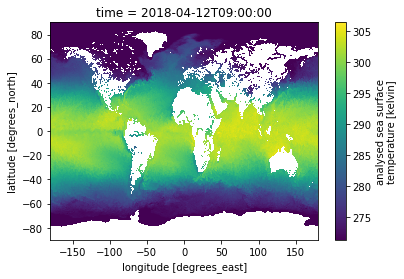

In [8]:
file,iexist=get_sat_filename(ds_usv.time[0])
ds=xr.open_dataset(file)
ds.analysed_sst.plot()
tem=ds.analysed_sst.sel(lat=slice(10,20),lon=slice(-150,-140)).mean({'lat','lon'})


In [16]:
print(tem)

<xarray.DataArray 'analysed_sst' (time: 1)>
array([298.94998], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2018-04-12T09:00:00


In [5]:
filename_collocation_data = 'F:/data/cruise_data/saildrone/baja-2018/ccmp_collocation_data.nc'
#filename_usv = 'https://podaac-opendap.jpl.nasa.gov/opendap/hyrax/allData/insitu/L2/saildrone/Baja/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1.nc'
filename_usv='f:/data/cruise_data/saildrone/baja-2018/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1.nc'
ds_usv = xr.open_dataset(filename_usv)
ds_usv.close()
ds_usv = ds_usv.isel(trajectory=0).swap_dims({'obs':'time'}).rename({'longitude':'lon','latitude':'lat'})
ds_usv = ds_usv.sel(time=slice('2018-04-12T02','2018-06-10T18')) #get rid of last part and first part where USV being towed
ds_usv['lon'] = ds_usv.lon.interpolate_na(dim='time',method='linear') #there are 6 nan values
ds_usv['lat'] = ds_usv.lat.interpolate_na(dim='time',method='linear')
ds_usv['wind_speed']=np.sqrt(ds_usv.UWND_MEAN**2+ds_usv.VWND_MEAN**2)
ds_usv['wind_dir']=np.arctan2(ds_usv.VWND_MEAN,ds_usv.UWND_MEAN)*180/np.pi
ds_usv_subset = ds_usv.copy(deep=True)
ds_usv_subset = ds_usv_subset.where(np.logical_not((ds_usv.time.dt.hour>12)&(ds_usv.wind_speed<7.5)))
ds_usv_subset = ds_usv_subset.where(np.logical_not((ds_usv.time.dt.hour<6)&(ds_usv.wind_speed<7.5)))
ds_usv_subset = ds_usv_subset.where(np.logical_not((ds_usv.time>np.datetime64('2018-05-24T12')) & (ds_usv.time<np.datetime64('2018-05-26T12'))))
#ds_usv_subset = ds_usv.dropna(dim='time',subset={'UWND_MEAN'})   #get rid of all the nan
#print(ds_usv_subset.UWND_MEAN[2000:2010].values)

In order to use open_mfdataset you need to either provide a path or a list of filenames to input

Here we use the USV cruise start and end date to read in all data for that period

In [3]:
read_date,end_date = ds_usv_subset.time.min(),ds_usv_subset.time.max()
filelist = []
while read_date<=(end_date+np.timedelta64(1,'D')):
    tem_filename,exists = get_sat_filename(read_date)
    if exists:
        filelist.append(tem_filename)
    read_date=read_date+np.timedelta64(1,'D')
print(filelist[0])

F:/data/sst/jpl_mur/v4.1/2018/102/20180412090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc


# Read in MUR data
Read in data using open_mfdataset with the option coords='minimal'

The dataset is printed out and you can see that rather than straight xarray data array for each of the data variables open_mfdataset using dask arrays

In [4]:
ds_sat = xr.open_mfdataset(filelist,coords='minimal')
ds_sat

<xarray.Dataset>
Dimensions:           (lat: 17999, lon: 36000, time: 1)
Coordinates:
  * time              (time) datetime64[ns] 2018-04-12T09:00:00
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -179.99 -179.98 -179.97 ... 179.99 180.0
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
    dt_1km_data       (time, lat, lon) timedelta64[ns] ...
Attributes:
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
  

# Xarray interpolation won't run on chunked dimensions.  
1. First let's subset the data to make it smaller to deal with by using the cruise lat/lons

1. Now load the data into memory (de-Dask-ify) it  


In [151]:
#Step 1 from above
print('min max lat lon:', ds_usv_subset.lon.min().data,ds_usv_subset.lon.max().data,ds_usv_subset.lat.min().data,ds_usv_subset.lat.max().data)
subset = ds_sat.sel(lon=slice(ds_usv_subset.lon.min().data,ds_usv_subset.lon.max().data),
                    lat=slice(ds_usv_subset.lat.min().data,ds_usv_subset.lat.max().data))
#Step 2 from above
subset.load()

min max lat lon: -125.55297279999999 -115.5226624 28.0176832 37.6797408


<xarray.Dataset>
Dimensions:           (lat: 966, lon: 1003, time: 61)
Coordinates:
  * lat               (lat) float32 28.02 28.03 28.04 ... 37.65 37.66 37.67
  * lon               (lon) float32 -125.55 -125.54 -125.53 ... -115.54 -115.53
  * time              (time) datetime64[ns] 2018-04-12T09:00:00 ... 2018-06-11T09:00:00
Data variables:
    analysed_sst      (time, lat, lon) float32 291.72998 291.722 ... nan nan
    analysis_error    (time, lat, lon) float32 0.39 0.39 0.39 ... nan nan nan
    mask              (time, lat, lon) float32 1.0 1.0 1.0 1.0 ... 2.0 2.0 2.0
    sea_ice_fraction  (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    dt_1km_data       (time, lat, lon) timedelta64[ns] 2 days 02:00:00 ... NaT
Attributes:
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_

# Collocate USV data with MUR data
There are different options when you interpolate.  First, let's just do a linear interpolation

In [152]:

ds_collocated = subset.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='linear')


# Collocate USV data with MUR data
There are different options when you interpolate.  First, let's just do a nearest point rather than interpolate the data

In [153]:
ds_collocated_nearest = subset.interp(lat=ds_usv_subset.lat,lon=ds_usv_subset.lon,time=ds_usv_subset.time,method='nearest')


# A larger STD that isn't reflective of uncertainty in the observation
The collocation above will result in multiple USV data points matched with a single satellite
observation.    The USV is sampling every 1 min and approximately few meters, while the satellite
is an average over a footprint that is interpolated onto a daily mean map.  While calculating the mean would results in a valid mean, the STD would be higher and consist of a component that reflects the uncertainty of the USV and the satellite and a component that reflects the natural variability in the region that is sampled by the USV

Below we use the 'nearest' collocation results to identify when multiple USV data are collcated to
a single satellite observation.
This code goes through the data and creates averages of the USV data that match the single CCMP collocated value.


In [182]:
ilen,index = ds_collocated_nearest.dims['time'],0
ds_tem = ds_collocated_nearest.copy(deep=True)
duu, duv1, duv2, dlat, dlon, dut = [],[],[],[],[],np.empty((),dtype='datetime64')
while index <= ilen-2:
    index += 1
    if np.isnan(ds_collocated_nearest.analysed_sst[index]):
        continue
    if np.isnan(ds_tem.analysed_sst[index]):
        continue
   # print(index, ilen)
    iend = index + 1000
    if iend > ilen-1:
        iend = ilen-1
    ds_tem_subset = ds_tem.analysed_sst[index:iend]
    ds_usv_subset2sst = ds_usv_subset.TEMP_CTD_MEAN[index:iend]
    ds_usv_subset2uwnd = ds_usv_subset.UWND_MEAN[index:iend]
    ds_usv_subset2vwnd = ds_usv_subset.VWND_MEAN[index:iend]
    ds_usv_subset2lat = ds_usv_subset.lat[index:iend]
    ds_usv_subset2lon = ds_usv_subset.lon[index:iend]
    ds_usv_subset2time = ds_usv_subset.time[index:iend]
    cond = ((ds_tem_subset==ds_collocated_nearest.analysed_sst[index]))
    notcond = np.logical_not(cond)
    #cond = ((ds_tem.analysed_sst==ds_collocated_nearest.analysed_sst[index]))
    #notcond = np.logical_not(cond)
    masked = ds_tem_subset.where(cond)
    if cond.sum().data==0:  #don't do if data not found
        continue
    if cond.sum().data>800:
        print(cond.sum().data,index,ds_tem.time[index].data)
    masked_usvsst = ds_usv_subset2sst.where(cond,drop=True)
    masked_usvuwnd = ds_usv_subset2uwnd.where(cond,drop=True)
    masked_usvvwnd = ds_usv_subset2vwnd.where(cond,drop=True)
    masked_usvlat = ds_usv_subset2lat.where(cond,drop=True)
    masked_usvlon = ds_usv_subset2lon.where(cond,drop=True)
    masked_usvtime = ds_usv_subset2time.where(cond,drop=True)
    duu=np.append(duu,masked_usvsst.mean().data)
    duv1=np.append(duv1,masked_usvuwnd.mean().data)
    duv2=np.append(duv2,masked_usvvwnd.mean().data)
    dlat=np.append(dlat,masked_usvlat.mean().data)
    dlon=np.append(dlon,masked_usvlon.mean().data)
    tdif = masked_usvtime[-1].data-masked_usvtime[0].data
    mtime=masked_usvtime[0].data+np.timedelta64(tdif/2,'ns')
    if mtime>dut.max():
        print(index,masked_usvtime[0].data,(masked_usvtime[-1].data-masked_usvtime[0].data)/1e9)
    dut=np.append(dut,mtime)
    ds_tem.analysed_sst[index:iend]=ds_tem.analysed_sst.where(notcond)
#    ds_tem=ds_tem.where(notcond,np.nan)  #masked used values by setting to nan
dut2 = dut[1:]  #remove first data point which is a repeat from what array defined    
ds_new=xr.Dataset(data_vars={'sst_usv': ('time',duu),'uwnd_usv': ('time',duv1),'vwnd_usv': ('time',duv2),
                             'lon': ('time',dlon),
                             'lat': ('time',dlat)},
                  coords={'time':dut2})
ds_new.to_netcdf('F:/data/cruise_data/saildrone/baja-2018/mur_downsampled_usv_data2.nc')

420 2018-04-12T09:00:00.000000000 60 nanoseconds
422 2018-04-12T09:02:00.000000000 540 nanoseconds
432 2018-04-12T09:12:00.000000000 480 nanoseconds
441 2018-04-12T09:21:00.000000000 360 nanoseconds
448 2018-04-12T09:28:00.000000000 120 nanoseconds
451 2018-04-12T09:31:00.000000000 480 nanoseconds
460 2018-04-12T09:40:00.000000000 240 nanoseconds
465 2018-04-12T09:45:00.000000000 480 nanoseconds
474 2018-04-12T09:54:00.000000000 540 nanoseconds
484 2018-04-12T10:04:00.000000000 480 nanoseconds
493 2018-04-12T10:13:00.000000000 0 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


494 2018-04-12T10:14:00.000000000 420 nanoseconds
502 2018-04-12T10:22:00.000000000 240 nanoseconds
507 2018-04-12T10:27:00.000000000 240 nanoseconds
512 2018-04-12T10:32:00.000000000 600 nanoseconds
523 2018-04-12T10:43:00.000000000 0 nanoseconds
524 2018-04-12T10:44:00.000000000 540 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


534 2018-04-12T10:54:00.000000000 600 nanoseconds
545 2018-04-12T11:05:00.000000000 0 nanoseconds
546 2018-04-12T11:06:00.000000000 720 nanoseconds
559 2018-04-12T11:19:00.000000000 600 nanoseconds
570 2018-04-12T11:30:00.000000000 1380 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


582 2018-04-12T11:42:00.000000000 0 nanoseconds
594 2018-04-12T11:54:00.000000000 600 nanoseconds
605 2018-04-12T12:05:00.000000000 540 nanoseconds
615 2018-04-12T12:15:00.000000000 540 nanoseconds
625 2018-04-12T12:25:00.000000000 660 nanoseconds
637 2018-04-12T12:37:00.000000000 600 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


648 2018-04-12T12:48:00.000000000 0 nanoseconds
649 2018-04-12T12:49:00.000000000 720 nanoseconds
662 2018-04-12T13:02:00.000000000 600 nanoseconds
669 2018-04-12T13:09:00.000000000 0 nanoseconds
673 2018-04-12T13:13:00.000000000 720 nanoseconds
686 2018-04-12T13:26:00.000000000 840 nanoseconds
701 2018-04-12T13:41:00.000000000 56520 nanoseconds
729 2018-04-12T14:09:00.000000000 55500 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

1112 2018-04-12T20:32:00.000000000 47400 nanoseconds
1123 2018-04-12T20:43:00.000000000 47280 nanoseconds
1731 2018-04-13T06:51:00.000000000 34140 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2007 2018-04-13T11:27:00.000000000 1260 nanoseconds
2029 2018-04-13T11:49:00.000000000 0 nanoseconds
2030 2018-04-13T11:50:00.000000000 660 nanoseconds
2042 2018-04-13T12:02:00.000000000 0 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2043 2018-04-13T12:03:00.000000000 720 nanoseconds
2056 2018-04-13T12:16:00.000000000 0 nanoseconds
2057 2018-04-13T12:17:00.000000000 660 nanoseconds
2069 2018-04-13T12:29:00.000000000 360 nanoseconds
2076 2018-04-13T12:36:00.000000000 180 nanoseconds
2080 2018-04-13T12:40:00.000000000 660 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2092 2018-04-13T12:52:00.000000000 60 nanoseconds
2094 2018-04-13T12:54:00.000000000 540 nanoseconds
2104 2018-04-13T13:04:00.000000000 480 nanoseconds
2113 2018-04-13T13:13:00.000000000 120 nanoseconds
2116 2018-04-13T13:16:00.000000000 720 nanoseconds
2129 2018-04-13T13:29:00.000000000 0 nanoseconds
2130 2018-04-13T13:30:00.000000000 780 nanoseconds
2144 2018-04-13T13:44:00.000000000 0 nanoseconds
2145 2018-04-13T13:45:00.000000000 720 nanoseconds
2158

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-04-13T13:58:00.000000000 720 nanoseconds
2171 2018-04-13T14:11:00.000000000 600 nanoseconds
2182 2018-04-13T14:22:00.000000000 600 nanoseconds
2193 2018-04-13T14:33:00.000000000 840 nanoseconds
2208 2018-04-13T14:48:00.000000000 120 nanoseconds
2211 2018-04-13T14:51:00.000000000 600 nanoseconds
2222 2018-04-13T15:02:00.000000000 120 nanoseconds
2225 2018-04-13T15:05:00.000000000 600 nanoseconds
2236 2018-04-13T15:16:00.000000000 240 nanoseconds
2241 2018-04-13T15:21:00.000000000 660 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2253 2018-04-13T15:33:00.000000000 420 nanoseconds
2261 2018-04-13T15:41:00.000000000 540 nanoseconds
2271 2018-04-13T15:51:00.000000000 2580 nanoseconds
2301 2018-04-13T16:21:00.000000000 120 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2315 2018-04-13T16:35:00.000000000 0 nanoseconds
2316 2018-04-13T16:36:00.000000000 720 nanoseconds
2329 2018-04-13T16:49:00.000000000 660 nanoseconds
2341 2018-04-13T17:01:00.000000000 0 nanoseconds
2342 2018-04-13T17:02:00.000000000 540 nanoseconds
2352 2018-04-13T17:12:00.000000000 180 nanoseconds
2356 2018-04-13T17:16:00.000000000 300 nanoseconds
2362 2018-04-13T17:22:00.000000000 480 nanoseconds
2371 2018-04-13T17:31:00.000000000 420 nanoseconds
2379 2018-04-13T17:39:00.000000000 300 nanoseconds
2385 2018-04-13T17:45:00.000000000 420 nanoseconds
2393 2018-04-13T17:53:00.000000000 420 nanoseconds
2401 2018-04-13T18:01:00.000000000 420 nanoseconds
2409 2018-04-13T18:09:00.000000000 420 nanoseconds
2417 2018-04-13T18:17:00.000000000 420 nanoseconds
2425 2018-04-13T18:25:00.000000000 420 nanoseconds
2433 2018-04-13T18:33:00.000000000 120 nanoseconds
2436 2018-04-13T18:36:00.000000000 360 nanoseconds
2443 2018-04-13T18:43:00.000000000 120 nanoseconds
2446 2018-04-13T18:46:00.000000000 

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2463 2018-04-13T19:03:00.000000000 300 nanoseconds
2469 2018-04-13T19:09:00.000000000 360 nanoseconds
2476 2018-04-13T19:16:00.000000000 300 nanoseconds
2482 2018-04-13T19:22:00.000000000 180 nanoseconds
2486 2018-04-13T19:26:00.000000000 0 nanoseconds
2487 2018-04-13T19:27:00.000000000 240 nanoseconds
2492 2018-04-13T19:32:00.000000000 360 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2499 2018-04-13T19:39:00.000000000 300 nanoseconds
2505 2018-04-13T19:45:00.000000000 300 nanoseconds
2511 2018-04-13T19:51:00.000000000 360 nanoseconds
2518 2018-04-13T19:58:00.000000000 240 nanoseconds
2523 2018-04-13T20:03:00.000000000 19620 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2693 2018-04-13T22:53:00.000000000 240 nanoseconds
2706 2018-04-13T23:06:00.000000000 60 nanoseconds
2728 2018-04-13T23:28:00.000000000 540 nanoseconds
2738 2018-04-13T23:38:00.000000000 480 nanoseconds
2747 2018-04-13T23:47:00.000000000 300 nanoseconds
2748

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-04-13T23:48:00.000000000 420 nanoseconds
2756 2018-04-13T23:56:00.000000000 540 nanoseconds
2766 2018-04-14T00:06:00.000000000 180 nanoseconds
2770 2018-04-14T00:10:00.000000000 240 nanoseconds
2775 2018-04-14T00:15:00.000000000 420 nanoseconds
2783

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-04-14T00:23:00.000000000 420 nanoseconds
2791 2018-04-14T00:31:00.000000000 420 nanoseconds
2799 2018-04-14T00:39:00.000000000 360 nanoseconds
2806 2018-04-14T00:46:00.000000000 360 nanoseconds
2813 2018-04-14T00:53:00.000000000 360 nanoseconds
2820 2018-04-14T01:00:00.000000000 360 nanoseconds
2827 2018-04-14T01:07:00.000000000 420 nanoseconds
2851 2018-04-14T01:31:00.000000000 420 nanoseconds
2859 2018-04-14T01:39:00.000000000 420 nanoseconds
2867 2018-04-14T01:47:00.000000000 420 nanoseconds
2875 2018-04-14T01:55:00.000000000 660 nanoseconds
2887 2018-04-14T02:07:00.000000000 39960 nanoseconds
2890 2018-04-14T02:10:00.000000000 40800 nanoseconds
2900 2018-04-14T02:20:00.000000000 41040 nanoseconds
2912 2018-04-14T02:32:00.000000000 41160 nanoseconds
2980 2018-04-14T03:40:00.000000000 33480 nanoseconds
2997 2018-04-14T03:57:00.000000000 32880 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


3599 2018-04-14T13:59:00.000000000 480 nanoseconds
3608 2018-04-14T14:08:00.000000000 540 nanoseconds
3618 2018-04-14T14:18:00.000000000 420 nanoseconds
3626 2018-04-14T14:26:00.000000000 420 nanoseconds
3634 2018-04-14T14:34:00.000000000 420 nanoseconds
3642 2018-04-14T14:42:00.000000000 420 nanoseconds
3650 2018-04-14T14:50:00.000000000 360 nanoseconds
3657 2018-04-14T14:57:00.000000000 360 nanoseconds
3664 2018-04-14T15:04:00.000000000 420 nanoseconds
3672 2018-04-14T15:12:00.000000000 360 nanoseconds
3679 2018-04-14T15:19:00.000000000 420 nanoseconds
3687 2018-04-14T15:27:00.000000000 420 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


3695 2018-04-14T15:35:00.000000000 600 nanoseconds
3706 2018-04-14T15:46:00.000000000 180 nanoseconds
3710 2018-04-14T15:50:00.000000000 420 nanoseconds
3718 2018-04-14T15:58:00.000000000 720 nanoseconds
3731 2018-04-14T16:11:00.000000000 960 nanoseconds
3748 2018-04-14T16:28:00.000000000 960 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

3765 2018-04-14T16:45:00.000000000 1020 nanoseconds
3783 2018-04-14T17:03:00.000000000 780 nanoseconds
3797 2018-04-14T17:17:00.000000000 60 nanoseconds
3799 2018-04-14T17:19:00.000000000 540 nanoseconds
3809 2018-04-14T17:29:00.000000000 780 nanoseconds
3823 2018-04-14T17:43:00.000000000 840 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

3838 2018-04-14T17:58:00.000000000 1860 nanoseconds
3853 2018-04-14T18:13:00.000000000 1560 nanoseconds
3880 2018-04-14T18:40:00.000000000 600 nanoseconds
3891 2018-04-14T18:51:00.000000000 420 nanoseconds
3899 2018-04-14T18:59:00.000000000 120 nanoseconds
3902 2018-04-14T19:02:00.000000000 780 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


3916 2018-04-14T19:16:00.000000000 120 nanoseconds
3919 2018-04-14T19:19:00.000000000 240 nanoseconds
3924 2018-04-14T19:24:00.000000000 420 nanoseconds
3932 2018-04-14T19:32:00.000000000 420 nanoseconds
3940 2018-04-14T19:40:00.000000000 480 nanoseconds
3949 2018-04-14T19:49:00.000000000 360 nanoseconds
3956 2018-04-14T19:56:00.000000000 480 nanoseconds
3965 2018-04-14T20:05:00.000000000 660 nanoseconds
3977 2018-04-14T20:17:00.000000000 660 nanoseconds
3989 2018-04-14T20:29:00.000000000 600 nanoseconds
4000 2018-04-14T20:40:00.000000000 660 nanoseconds
4012 2018-04-14T20:52:00.000000000 59340 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

4383 2018-04-15T03:03:00.000000000 15480 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


4477 2018-04-15T04:37:00.000000000 34800 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


4557 2018-04-15T05:57:00.000000000 54180 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


4946 2018-04-15T12:26:00.000000000 8160 nanoseconds
5036 2018-04-15T13:56:00.000000000 1920 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


5083 2018-04-15T14:43:00.000000000 16980 nanoseconds
5092 2018-04-15T14:52:00.000000000 16920 nanoseconds
5103 2018-04-15T15:03:00.000000000 17280 nanoseconds
5124 2018-04-15T15:24:00.000000000 17040 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


5153 2018-04-15T15:53:00.000000000 17340 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


5461 2018-04-15T21:01:00.000000000 3900 nanoseconds
5519 2018-04-15T21:59:00.000000000 3480 nanoseconds
5578 2018-04-15T22:58:00.000000000 360 nanoseconds
5585 2018-04-15T23:05:00.000000000 900 nanoseconds
5601 2018-04-15T23:21:00.000000000 1500 nanoseconds
5627 2018-04-15T23:47:00.000000000 780 nanoseconds
5641 2018-04-16T00:01:00.000000000 180 nanoseconds
5645 2018-04-16T00:05:00.000000000 540 nanoseconds
5655 2018-04-16T00:15:00.000000000 420 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


5663 2018-04-16T00:23:00.000000000 240 nanoseconds
5668 2018-04-16T00:28:00.000000000 840 nanoseconds
5683 2018-04-16T00:43:00.000000000 0 nanoseconds
5684 2018-04-16T00:44:00.000000000 720 nanoseconds
5697 2018-04-16T00:57:00.000000000 360 nanoseconds
5704 2018-04-16T01:04:00.000000000 300 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

5710 2018-04-16T01:10:00.000000000 540 nanoseconds
5720 2018-04-16T01:20:00.000000000 60 nanoseconds
5722 2018-04-16T01:22:00.000000000 720 nanoseconds
5735 2018-04-16T01:35:00.000000000 180 nanoseconds
5739 2018-04-16T01:39:00.000000000 480 nanoseconds
5748

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-04-16T01:48:00.000000000 540 nanoseconds
5758 2018-04-16T01:58:00.000000000 180 nanoseconds
5762 2018-04-16T02:02:00.000000000 660 nanoseconds
5774 2018-04-16T02:14:00.000000000 0 nanoseconds
5775 2018-04-16T02:15:00.000000000 540 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


5785 2018-04-16T02:25:00.000000000 300 nanoseconds
5791 2018-04-16T02:31:00.000000000 240 nanoseconds
5796 2018-04-16T02:36:00.000000000 540 nanoseconds
5806 2018-04-16T02:46:00.000000000 0 nanoseconds
5807 2018-04-16T02:47:00.000000000 660 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


5819 2018-04-16T02:59:00.000000000 120 nanoseconds
5822 2018-04-16T03:02:00.000000000 420 nanoseconds
5830 2018-04-16T03:10:00.000000000 420 nanoseconds
5838 2018-04-16T03:18:00.000000000 180 nanoseconds
5842 2018-04-16T03:22:00.000000000 720 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

5855 2018-04-16T03:35:00.000000000 60 nanoseconds
5857 2018-04-16T03:37:00.000000000 720 nanoseconds
5870 2018-04-16T03:50:00.000000000 420 nanoseconds
5878 2018-04-16T03:58:00.000000000 360 nanoseconds
5885 2018-04-16T04:05:00.000000000 900 nanoseconds
5901 2018-04-16T04:21:00.000000000 1080 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


5920 2018-04-16T04:40:00.000000000 360 nanoseconds
5927 2018-04-16T04:47:00.000000000 600 nanoseconds
5938 2018-04-16T04:58:00.000000000 900 nanoseconds
5954 2018-04-16T05:14:00.000000000 180 nanoseconds
5958 2018-04-16T05:18:00.000000000 27660 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


6019 2018-04-16T06:19:00.000000000 57960 nanoseconds
6073 2018-04-16T07:13:00.000000000 55860 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


6388 2018-04-16T12:28:00.000000000 49380 nanoseconds
6434 2018-04-16T13:14:00.000000000 47160 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

6795 2018-04-16T19:15:00.000000000 54720 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

7249 2018-04-17T02:49:00.000000000 540 nanoseconds
7259 2018-04-17T02:59:00.000000000 120 nanoseconds
7262 2018-04-17T03:02:00.000000000 26400 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


7304 2018-04-17T03:44:00.000000000 22500 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


7430 2018-04-17T05:50:00.000000000 41220 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


7495 2018-04-17T06:55:00.000000000 36960 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


7658 2018-04-17T09:38:00.000000000 22740 nanoseconds
7726 2018-04-17T10:46:00.000000000 15960 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


7857 2018-04-17T12:57:00.000000000 420 nanoseconds
7865 2018-04-17T13:05:00.000000000 300 nanoseconds
7871 2018-04-17T13:11:00.000000000 180 nanoseconds
7884 2018-04-17T13:24:00.000000000 0 nanoseconds
7885 2018-04-17T13:25:00.000000000 26580 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


7950 2018-04-17T14:30:00.000000000 21660 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

8128 2018-04-17T17:28:00.000000000 480 nanoseconds
8137 2018-04-17T17:37:00.000000000 240 nanoseconds
8142 2018-04-17T17:42:00.000000000 120 nanoseconds
8145 2018-04-17T17:45:00.000000000 7380 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


8208 2018-04-17T18:48:00.000000000 0 nanoseconds
8209 2018-04-17T18:49:00.000000000 420 nanoseconds
8217 2018-04-17T18:57:00.000000000 360 nanoseconds
8224 2018-04-17T19:04:00.000000000 0 nanoseconds
8233 2018-04-17T19:13:00.000000000 360 nanoseconds
8240 2018-04-17T19:20:00.000000000 0 nanoseconds
8241 2018-04-17T19:21:00.000000000 360 nanoseconds
8248 2018-04-17T19:28:00.000000000 360 nanoseconds
8255 2018-04-17T19:35:00.000000000 360 nanoseconds
8269 2018-04-17T19:49:00.000000000 300 nanoseconds
8275 2018-04-17T19:55:00.000000000 360 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


8282 2018-04-17T20:02:00.000000000 0 nanoseconds
8283 2018-04-17T20:03:00.000000000 300 nanoseconds
8289 2018-04-17T20:09:00.000000000 360 nanoseconds
8296 2018-04-17T20:16:00.000000000 60 nanoseconds
8298 2018-04-17T20:18:00.000000000 180 nanoseconds
8302 2018-04-17T20:22:00.000000000 360 nanoseconds
8312 2018-04-17T20:32:00.000000000 180 nanoseconds
8316 2018-04-17T20:36:00.000000000 56520 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


8380 2018-04-17T21:40:00.000000000 49080 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


8488 2018-04-17T23:28:00.000000000 41400 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

8830 2018-04-18T05:10:00.000000000 4740 nanoseconds
8873 2018-04-18T05:53:00.000000000 420 nanoseconds
8881 2018-04-18T06:01:00.000000000 300 nanoseconds
8887 2018-04-18T06:07:00.000000000 120 nanoseconds
8890 2018-04-18T06:10:00.000000000 420 nanoseconds
8898 2018-04-18T06:18:00.000000000 480 nanoseconds
8910 2018-04-18T06:30:00.000000000 240 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


8915 2018-04-18T06:35:00.000000000 480 nanoseconds
8924 2018-04-18T06:44:00.000000000 360 nanoseconds
8931 2018-04-18T06:51:00.000000000 60 nanoseconds
8933 2018-04-18T06:53:00.000000000 480 nanoseconds
8942 2018-04-18T07:02:00.000000000 480 nanoseconds
8951 2018-04-18T07:11:00.000000000 0 nanoseconds
8952

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-04-18T07:12:00.000000000 420 nanoseconds
8970 2018-04-18T07:30:00.000000000 120 nanoseconds
8973 2018-04-18T07:33:00.000000000 360 nanoseconds
8980 2018-04-18T07:40:00.000000000 600 nanoseconds
8991 2018-04-18T07:51:00.000000000 300 nanoseconds
8997 2018-04-18T07:57:00.000000000 180 nanoseconds
9001 2018-04-18T08:01:00.000000000 600 nanoseconds
9012 2018-04-18T08:12:00.000000000 600 nanoseconds
9023 2018-04-18T08:23:00.000000000 600 nanoseconds
9034 2018-04-18T08:34:00.000000000 600 nanoseconds
9045 2018-04-18T08:45:00.000000000 300 nanoseconds
9051 2018-04-18T08:51:00.000000000 240 nanoseconds
9056 2018-04-18T08:56:00.000000000 600 nanoseconds
9067 2018-04-18T09:07:00.000000000 600 nanoseconds
9078 2018-04-18T09:18:00.000000000 180 nanoseconds
9082 2018-04-18T09:22:00.000000000 360 nanoseconds
9089 2018-04-18T09:29:00.000000000 660 nanoseconds
9101 2018-04-18T09:41:00.000000000 660 nanoseconds
9113 2018-04-18T09:53:00.000000000 600 nanoseconds
9124 2018-04-18T10:04:00.000000000 

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


9147 2018-04-18T10:27:00.000000000 600 nanoseconds
9158 2018-04-18T10:38:00.000000000 540 nanoseconds
9179 2018-04-18T10:59:00.000000000 540 nanoseconds
9199 2018-04-18T11:19:00.000000000 540 nanoseconds
9209 2018-04-18T11:29:00.000000000 540 nanoseconds
9219 2018-04-18T11:39:00.000000000 480 nanoseconds
9228 2018-04-18T11:48:00.000000000 0 nanoseconds
9229 2018-04-18T11:49:00.000000000 540 nanoseconds
9239 2018-04-18T11:59:00.000000000 540 nanoseconds
9259 2018-04-18T12:19:00.000000000 0 nanoseconds
9260

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-04-18T12:20:00.000000000 480 nanoseconds
9269 2018-04-18T12:29:00.000000000 780 nanoseconds
9283 2018-04-18T12:43:00.000000000 840 nanoseconds
9298 2018-04-18T12:58:00.000000000 720 nanoseconds
9311 2018-04-18T13:11:00.000000000 660 nanoseconds
9323 2018-04-18T13:23:00.000000000 56520 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


9520 2018-04-18T16:40:00.000000000 43500 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


9781 2018-04-18T21:01:00.000000000 16320 nanoseconds
9789 2018-04-18T21:09:00.000000000 16320 nanoseconds
9795 2018-04-18T21:15:00.000000000 16560 nanoseconds
9803 2018-04-18T21:23:00.000000000 16680 nanoseconds
9811 2018-04-18T21:31:00.000000000 17280 nanoseconds
9820 2018-04-18T21:40:00.000000000 17700 nanoseconds
9830 2018-04-18T21:50:00.000000000 18000 nanoseconds
9841 2018-04-18T22:01:00.000000000 18180 nanoseconds
9851 2018-04-18T22:11:00.000000000 18300 nanoseconds
9861 2018-04-18T22:21:00.000000000 18300 nanoseconds
9868 2018-04-18T22:28:00.000000000 18480 nanoseconds
9876 2018-04-18T22:36:00.000000000 18660 nanoseconds
9887 2018-04-18T22:47:00.000000000 18600 nanoseconds
10198 2018-04-19T03:58:00.000000000 540 nanoseconds
10208 2018-04-19T04:08:00.000000000 480 nanoseconds
10217 2018-04-19T04:17:00.000000000 540 nanoseconds
10227 2018-04-19T04:27:00.000000000 480 nanoseconds
10246 2018-04-19T04:46:00.000000000 600 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


10266 2018-04-19T05:06:00.000000000 120 nanoseconds
10269 2018-04-19T05:09:00.000000000 360 nanoseconds
10276 2018-04-19T05:16:00.000000000 540 nanoseconds
10286 2018-04-19T05:26:00.000000000 540 nanoseconds
10296 2018-04-19T05:36:00.000000000 480 nanoseconds
10305 2018-04-19T05:45:00.000000000 60 nanoseconds
10307 2018-04-19T05:47:00.000000000 420 nanoseconds
10315 2018-04-19T05:55:00.000000000 360 nanoseconds
10322 2018-04-19T06:02:00.000000000 60 nanoseconds
10324 2018-04-19T06:04:00.000000000 240 nanoseconds
10329 2018-04-19T06:09:00.000000000 180 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


10333 2018-04-19T06:13:00.000000000 540 nanoseconds
10343 2018-04-19T06:23:00.000000000 480 nanoseconds
10352 2018-04-19T06:32:00.000000000 540 nanoseconds
10362 2018-04-19T06:42:00.000000000 540 nanoseconds
10372 2018-04-19T06:52:00.000000000 540 nanoseconds
10382 2018-04-19T07:02:00.000000000 540 nanoseconds
10392 2018-04-19T07:12:00.000000000 480 nanoseconds
10401 2018-04-19T07:21:00.000000000 540 nanoseconds
10411 2018-04-19T07:31:00.000000000 300 nanoseconds
10417 2018-04-19T07:37:00.000000000 780 nanoseconds
10431 2018-04-19T07:51:00.000000000 600 nanoseconds
10442 2018-04-19T08:02:00.000000000 660 nanoseconds
10454 2018-04-19T08:14:00.000000000 240 nanoseconds
10459 2018-04-19T08:19:00.000000000 360 nanoseconds
10466 2018-04-19T08:26:00.000000000 480 nanoseconds
10475 2018-04-19T08:35:00.000000000 540 nanoseconds
10485 2018-04-19T08:45:00.000000000 480 nanoseconds
10494 2018-04-19T08:54:00.000000000 240 nanoseconds
10499 2018-04-19T08:59:00.000000000 240 nanoseconds
10504 2018-0

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


10737 2018-04-19T12:57:00.000000000 720 nanoseconds
10750 2018-04-19T13:10:00.000000000 600 nanoseconds
10761 2018-04-19T13:21:00.000000000 960 nanoseconds
10778 2018-04-19T13:38:00.000000000 240 nanoseconds
10783 2018-04-19T13:43:00.000000000 300 nanoseconds
10789 2018-04-19T13:49:00.000000000 240 nanoseconds
10794 2018-04-19T13:54:00.000000000 360 nanoseconds
10801 2018-04-19T14:01:00.000000000 360 nanoseconds
10808 2018-04-19T14:08:00.000000000 360 nanoseconds
10815 2018-04-19T14:15:00.000000000 360 nanoseconds
10822 2018-04-19T14:22:00.000000000 360 nanoseconds
10829

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-04-19T14:29:00.000000000 360 nanoseconds
10836 2018-04-19T14:36:00.000000000 360 nanoseconds
10843 2018-04-19T14:43:00.000000000 300 nanoseconds
10849 2018-04-19T14:49:00.000000000 360 nanoseconds
10856 2018-04-19T14:56:00.000000000 360 nanoseconds
10863 2018-04-19T15:03:00.000000000 1200 nanoseconds
10873 2018-04-19T15:13:00.000000000 360 nanoseconds
10884 2018-04-19T15:24:00.000000000 120 nanoseconds
10887 2018-04-19T15:27:00.000000000 360 nanoseconds
10894 2018-04-19T15:34:00.000000000 360 nanoseconds
10901 2018-04-19T15:41:00.000000000 360 nanoseconds
10908 2018-04-19T15:48:00.000000000 360 nanoseconds
10915 2018-04-19T15:55:00.000000000 360 nanoseconds
10922 2018-04-19T16:02:00.000000000 360 nanoseconds
10929 2018-04-19T16:09:00.000000000 360 nanoseconds
10936 2018-04-19T16:16:00.000000000 59940 nanoseconds
10950 2018-04-19T16:30:00.000000000 59940 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


11410 2018-04-20T00:10:00.000000000 42780 nanoseconds
11451 2018-04-20T00:51:00.000000000 47040 nanoseconds
11458 2018-04-20T00:58:00.000000000 48300 nanoseconds
11466 2018-04-20T01:06:00.000000000 49380 nanoseconds
11473 2018-04-20T01:13:00.000000000 51600 nanoseconds
11833 2018-04-20T07:13:00.000000000 12900 nanoseconds
11936 2018-04-20T08:56:00.000000000 12300 nanoseconds
11950 2018-04-20T09:10:00.000000000 12780 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


12177 2018-04-20T12:57:00.000000000 120 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


12334 2018-04-20T15:34:00.000000000 1140 nanoseconds
12354 2018-04-20T15:54:00.000000000 1740 nanoseconds
12384 2018-04-20T16:24:00.000000000 2700 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


12430 2018-04-20T17:10:00.000000000 3780 nanoseconds
12494 2018-04-20T18:14:00.000000000 4200 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


12565 2018-04-20T19:25:00.000000000 1680 nanoseconds
12594 2018-04-20T19:54:00.000000000 1260 nanoseconds
12616 2018-04-20T20:16:00.000000000 2340 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


12656 2018-04-20T20:56:00.000000000 240 nanoseconds
12661 2018-04-20T21:01:00.000000000 1440 nanoseconds
12686 2018-04-20T21:26:00.000000000 120 nanoseconds
12689 2018-04-20T21:29:00.000000000 1260 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

12711 2018-04-20T21:51:00.000000000 1140 nanoseconds
12731 2018-04-20T22:11:00.000000000 60 nanoseconds
12733 2018-04-20T22:13:00.000000000 720 nanoseconds
12746 2018-04-20T22:26:00.000000000 240 nanoseconds
12751 2018-04-20T22:31:00.000000000 6720 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

12809 2018-04-20T23:29:00.000000000 120 nanoseconds
12812 2018-04-20T23:32:00.000000000 780 nanoseconds
12826 2018-04-20T23:46:00.000000000 0 nanoseconds
12827 2018-04-20T23:47:00.000000000 780 nanoseconds
12841 2018-04-21T00:01:00.000000000 120 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


12844 2018-04-21T00:04:00.000000000 21360 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

13028 2018-04-21T03:08:00.000000000 720 nanoseconds
13041 2018-04-21T03:21:00.000000000 660 nanoseconds
13053 2018-04-21T03:33:00.000000000 720 nanoseconds
13066 2018-04-21T03:46:00.000000000 660 nanoseconds
13078 2018-04-21T03:58:00.000000000 540 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

13088 2018-04-21T04:08:00.000000000 720 nanoseconds
13101 2018-04-21T04:21:00.000000000 360 nanoseconds
13108 2018-04-21T04:28:00.000000000 2340 nanoseconds
13148 2018-04-21T05:08:00.000000000 780 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


13162 2018-04-21T05:22:00.000000000 180 nanoseconds
13166 2018-04-21T05:26:00.000000000 1020 nanoseconds
13201 2018-04-21T06:01:00.000000000 41220 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


13272 2018-04-21T07:12:00.000000000 47460 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


13416 2018-04-21T09:36:00.000000000 37380 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


13630 2018-04-21T13:10:00.000000000 29040 nanoseconds
13649 2018-04-21T13:29:00.000000000 27180 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

13889 2018-04-21T17:29:00.000000000 900 nanoseconds
13905 2018-04-21T17:45:00.000000000 26220 nanoseconds
13934 2018-04-21T18:14:00.000000000 24900 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


13960 2018-04-21T18:40:00.000000000 41820 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

14155 2018-04-21T21:55:00.000000000 43500 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

14313 2018-04-22T00:33:00.000000000 34500 nanoseconds
14371 2018-04-22T01:31:00.000000000 27780 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

14598 2018-04-22T05:18:00.000000000 780 nanoseconds
14612 2018-04-22T05:32:00.000000000 780 nanoseconds
14658 2018-04-22T06:18:00.000000000 420 nanoseconds
14666 2018-04-22T06:26:00.000000000 960 nanoseconds
14683 2018-04-22T06:43:00.000000000 480 nanoseconds
14692 2018-04-22T06:52:00.000000000 1380 nanoseconds
14716 2018-04-22T07:16:00.000000000 1080 nanoseconds
14735 2018-04-22T07:35:00.000000000 1140 nanoseconds
14755 2018-04-22T07:55:00.000000000 1380 nanoseconds
14779 2018-04-22T08:19:00.000000000 480 nanoseconds
14788 2018-04-22T08:28:00.000000000 1260 nanoseconds
14810 2018-04-22T08:50:00.000000000 420 nanoseconds
14835 2018-04-22T09:15:00.000000000 780 nanoseconds
14889 2018-04-22T10:09:00.000000000 780 nanoseconds
14903 2018-04-22T10:23:00.000000000 840 nanoseconds
14918 2018-04-22T10:38:00.000000000 840 nanoseconds
14933 2018-04-22T10:53:00.000000000 840 nanoseconds
14948 2018-04-22T11:08:00.000000000 840 nanoseconds
14963 2018-04-22T11:23:00.000000000 600 nanoseconds
14974 2

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

15172 2018-04-22T14:52:00.000000000 840 nanoseconds
15187 2018-04-22T15:07:00.000000000 1020 nanoseconds
15205 2018-04-22T15:25:00.000000000 900 nanoseconds
15221 2018-04-22T15:41:00.000000000 120 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


15243 2018-04-22T16:03:00.000000000 1020 nanoseconds
15261 2018-04-22T16:21:00.000000000 1140 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


15281 2018-04-22T16:41:00.000000000 1200 nanoseconds
15302 2018-04-22T17:02:00.000000000 1080 nanoseconds
15321 2018-04-22T17:21:00.000000000 240 nanoseconds
15326 2018-04-22T17:26:00.000000000 600 nanoseconds
15337 2018-04-22T17:37:00.000000000 840 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

15352 2018-04-22T17:52:00.000000000 480 nanoseconds
15361 2018-04-22T18:01:00.000000000 420 nanoseconds
15369 2018-04-22T18:09:00.000000000 840 nanoseconds
15384 2018-04-22T18:24:00.000000000 420 nanoseconds
15392 2018-04-22T18:32:00.000000000 180 nanoseconds
15396 2018-04-22T18:36:00.000000000 660 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


15408 2018-04-22T18:48:00.000000000 540 nanoseconds
15418 2018-04-22T18:58:00.000000000 60 nanoseconds
15420 2018-04-22T19:00:00.000000000 660 nanoseconds
15432 2018-04-22T19:12:00.000000000 660 nanoseconds
15444 2018-04-22T19:24:00.000000000 600 nanoseconds
15455 2018-04-22T19:35:00.000000000 600 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


15466 2018-04-22T19:46:00.000000000 0 nanoseconds
15467 2018-04-22T19:47:00.000000000 480 nanoseconds
15476 2018-04-22T19:56:00.000000000 540 nanoseconds
15486 2018-04-22T20:06:00.000000000 60 nanoseconds
15488 2018-04-22T20:08:00.000000000 480 nanoseconds
15497 2018-04-22T20:17:00.000000000 660 nanoseconds
15509 2018-04-22T20:29:00.000000000 180 nanoseconds
15513 2018-04-22T20:33:00.000000000 420 nanoseconds
15521 2018-04-22T20:41:00.000000000 600 nanoseconds
15532 2018-04-22T20:52:00.000000000 240 nanoseconds
15537 2018-04-22T20:57:00.000000000 180 nanoseconds
15541 2018-04-22T21:01:00.000000000 120 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


15544 2018-04-22T21:04:00.000000000 660 nanoseconds
15556 2018-04-22T21:16:00.000000000 300 nanoseconds
15562 2018-04-22T21:22:00.000000000 360 nanoseconds
15569 2018-04-22T21:29:00.000000000 720 nanoseconds
15582 2018-04-22T21:42:00.000000000 600 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


15593 2018-04-22T21:53:00.000000000 60 nanoseconds
15595 2018-04-22T21:55:00.000000000 37020 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

15909 2018-04-23T03:09:00.000000000 2160 nanoseconds
15946 2018-04-23T03:46:00.000000000 7860 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


16011 2018-04-23T04:51:00.000000000 120 nanoseconds
16014 2018-04-23T04:54:00.000000000 1320 nanoseconds
16037 2018-04-23T05:17:00.000000000 1260 nanoseconds
16078 2018-04-23T05:58:00.000000000 1200 nanoseconds
16099 2018-04-23T06:19:00.000000000 1200 nanoseconds
16120 2018-04-23T06:40:00.000000000 1320 nanoseconds
16143 2018-04-23T07:03:00.000000000 1260 nanoseconds
16165 2018-04-23T07:25:00.000000000 1320 nanoseconds
16188 2018-04-23T07:48:00.000000000 780 nanoseconds
16213 2018-04-23T08:13:00.000000000 32940 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

16498 2018-04-23T12:58:00.000000000 1920 nanoseconds
16531 2018-04-23T13:31:00.000000000 780 nanoseconds
16545 2018-04-23T13:45:00.000000000 720 nanoseconds
16558 2018-04-23T13:58:00.000000000 1380 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


16582 2018-04-23T14:22:00.000000000 420 nanoseconds
16590 2018-04-23T14:30:00.000000000 960 nanoseconds
16607 2018-04-23T14:47:00.000000000 1140 nanoseconds
16627 2018-04-23T15:07:00.000000000 180 nanoseconds
16631 2018-04-23T15:11:00.000000000 1260 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


16653 2018-04-23T15:33:00.000000000 900 nanoseconds
16669 2018-04-23T15:49:00.000000000 240 nanoseconds
16674 2018-04-23T15:54:00.000000000 1200 nanoseconds
16695 2018-04-23T16:15:00.000000000 840 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


16710 2018-04-23T16:30:00.000000000 180 nanoseconds
16714 2018-04-23T16:34:00.000000000 1020 nanoseconds
16732 2018-04-23T16:52:00.000000000 1140 nanoseconds
16752 2018-04-23T17:12:00.000000000 300 nanoseconds
16763 2018-04-23T17:23:00.000000000 720 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


16776 2018-04-23T17:36:00.000000000 720 nanoseconds
16789 2018-04-23T17:49:00.000000000 720 nanoseconds
16802 2018-04-23T18:02:00.000000000 60 nanoseconds
16804 2018-04-23T18:04:00.000000000 600 nanoseconds
16815 2018-04-23T18:15:00.000000000 720 nanoseconds
16828 2018-04-23T18:28:00.000000000 780 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


16842 2018-04-23T18:42:00.000000000 840 nanoseconds
16857 2018-04-23T18:57:00.000000000 840 nanoseconds
16872 2018-04-23T19:12:00.000000000 480 nanoseconds
16881 2018-04-23T19:21:00.000000000 1320 nanoseconds
16904 2018-04-23T19:44:00.000000000 180 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

16908 2018-04-23T19:48:00.000000000 900 nanoseconds
16924 2018-04-23T20:04:00.000000000 1140 nanoseconds
16944 2018-04-23T20:24:00.000000000 120 nanoseconds
16947 2018-04-23T20:27:00.000000000 1980 nanoseconds
16961 2018-04-23T20:41:00.000000000 840 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


16976 2018-04-23T20:56:00.000000000 0 nanoseconds
16981 2018-04-23T21:01:00.000000000 660 nanoseconds
16993 2018-04-23T21:13:00.000000000 1920 nanoseconds
17003 2018-04-23T21:23:00.000000000 1740 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


17033 2018-04-23T21:53:00.000000000 660 nanoseconds
17045 2018-04-23T22:05:00.000000000 240 nanoseconds
17050 2018-04-23T22:10:00.000000000 360 nanoseconds
17057 2018-04-23T22:17:00.000000000 600 nanoseconds
17068 2018-04-23T22:28:00.000000000 180 nanoseconds
17072 2018-04-23T22:32:00.000000000 420 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


17080 2018-04-23T22:40:00.000000000 780 nanoseconds
17094 2018-04-23T22:54:00.000000000 0 nanoseconds
17095 2018-04-23T22:55:00.000000000 660 nanoseconds
17107 2018-04-23T23:07:00.000000000 600 nanoseconds
17118 2018-04-23T23:18:00.000000000 60 nanoseconds
17120 2018-04-23T23:20:00.000000000 720 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


17133 2018-04-23T23:33:00.000000000 780 nanoseconds
17147 2018-04-23T23:47:00.000000000 180 nanoseconds
17151 2018-04-23T23:51:00.000000000 480 nanoseconds
17160 2018-04-24T00:00:00.000000000 840 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


17175 2018-04-24T00:15:00.000000000 780 nanoseconds
17189 2018-04-24T00:29:00.000000000 660 nanoseconds
17201 2018-04-24T00:41:00.000000000 780 nanoseconds
17215 2018-04-24T00:55:00.000000000 840 nanoseconds
17230 2018-04-24T01:10:00.000000000 720 nanoseconds
17243 2018-04-24T01:23:00.000000000 780 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


17257 2018-04-24T01:37:00.000000000 720 nanoseconds
17270 2018-04-24T01:50:00.000000000 780 nanoseconds
17284 2018-04-24T02:04:00.000000000 15000 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

17415 2018-04-24T04:15:00.000000000 900 nanoseconds
17431 2018-04-24T04:31:00.000000000 120 nanoseconds
17434 2018-04-24T04:34:00.000000000 1260 nanoseconds
17456 2018-04-24T04:56:00.000000000 960 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


17476 2018-04-24T05:16:00.000000000 1200 nanoseconds
17497 2018-04-24T05:37:00.000000000 1140 nanoseconds
17517 2018-04-24T05:57:00.000000000 840 nanoseconds
17535 2018-04-24T06:15:00.000000000 1140 nanoseconds
17555 2018-04-24T06:35:00.000000000 660 nanoseconds
17567 2018-04-24T06:47:00.000000000 19140 nanoseconds
17583 2018-04-24T07:03:00.000000000 17400 nanoseconds
17617 2018-04-24T07:37:00.000000000 31140 nanoseconds
17733 2018-04-24T09:33:00.000000000 25200 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


17943 2018-04-24T13:03:00.000000000 720 nanoseconds
17956 2018-04-24T13:16:00.000000000 1140 nanoseconds
17994 2018-04-24T13:54:00.000000000 5220 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


18092 2018-04-24T15:32:00.000000000 480 nanoseconds
18101 2018-04-24T15:41:00.000000000 540 nanoseconds
18111 2018-04-24T15:51:00.000000000 480 nanoseconds
18137 2018-04-24T16:17:00.000000000 540 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


18154 2018-04-24T16:34:00.000000000 540 nanoseconds
18164 2018-04-24T16:44:00.000000000 600 nanoseconds
18175 2018-04-24T16:55:00.000000000 840 nanoseconds
18190 2018-04-24T17:10:00.000000000 300 nanoseconds
18196 2018-04-24T17:16:00.000000000 1140 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

18216 2018-04-24T17:36:00.000000000 0 nanoseconds
18217 2018-04-24T17:37:00.000000000 1020 nanoseconds
18235 2018-04-24T17:55:00.000000000 720 nanoseconds
18248 2018-04-24T18:08:00.000000000 120 nanoseconds
18251 2018-04-24T18:11:00.000000000 780 nanoseconds
18265

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-04-24T18:25:00.000000000 660 nanoseconds
18277 2018-04-24T18:37:00.000000000 120 nanoseconds
18280 2018-04-24T18:40:00.000000000 1080 nanoseconds
18299 2018-04-24T18:59:00.000000000 180 nanoseconds
18303 2018-04-24T19:03:00.000000000 1560 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

18330 2018-04-24T19:30:00.000000000 1080 nanoseconds
18349 2018-04-24T19:49:00.000000000 4560 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


18389 2018-04-24T20:29:00.000000000 1260 nanoseconds
18411 2018-04-24T20:51:00.000000000 420 nanoseconds
18419 2018-04-24T20:59:00.000000000 60 nanoseconds
18426 2018-04-24T21:06:00.000000000 43080 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

18782 2018-04-25T03:02:00.000000000 780 nanoseconds
18796 2018-04-25T03:16:00.000000000 120 nanoseconds
18799 2018-04-25T03:19:00.000000000 840 nanoseconds
18814 2018-04-25T03:34:00.000000000 180 nanoseconds
18818 2018-04-25T03:38:00.000000000 1020 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


18836 2018-04-25T03:56:00.000000000 1140 nanoseconds
18856 2018-04-25T04:16:00.000000000 840 nanoseconds
18871 2018-04-25T04:31:00.000000000 900 nanoseconds
18887 2018-04-25T04:47:00.000000000 900 nanoseconds
18903 2018-04-25T05:03:00.000000000 60 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


18905 2018-04-25T05:05:00.000000000 720 nanoseconds
18918 2018-04-25T05:18:00.000000000 900 nanoseconds
18934 2018-04-25T05:34:00.000000000 900 nanoseconds
18950 2018-04-25T05:50:00.000000000 240 nanoseconds
18955 2018-04-25T05:55:00.000000000 480 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


18964 2018-04-25T06:04:00.000000000 780 nanoseconds
18978 2018-04-25T06:18:00.000000000 660 nanoseconds
18990 2018-04-25T06:30:00.000000000 720 nanoseconds
19003 2018-04-25T06:43:00.000000000 780 nanoseconds
19017 2018-04-25T06:57:00.000000000 660 nanoseconds
19029 2018-04-25T07:09:00.000000000 600 nanoseconds
19040 2018-04-25T07:20:00.000000000 600 nanoseconds
19051 2018-04-25T07:31:00.000000000 540 nanoseconds
19061 2018-04-25T07:41:00.000000000 540 nanoseconds
19071 2018-04-25T07:51:00.000000000 600 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


19082 2018-04-25T08:02:00.000000000 0 nanoseconds
19083 2018-04-25T08:03:00.000000000 660 nanoseconds
19095 2018-04-25T08:15:00.000000000 720 nanoseconds
19108 2018-04-25T08:28:00.000000000 660 nanoseconds
19120 2018-04-25T08:40:00.000000000 660 nanoseconds
19145 2018-04-25T09:05:00.000000000 840 nanoseconds
19160 2018-04-25T09:20:00.000000000 0 nanoseconds
19161 2018-04-25T09:21:00.000000000 780 nanoseconds
19175 2018-04-25T09:35:00.000000000 780 nanoseconds
19189 2018-04-25T09:49:00.000000000 720 nanoseconds
19202 2018-04-25T10:02:00.000000000 720 nanoseconds
19215 2018-04-25T10:15:00.000000000 780 nanoseconds
19229 2018-04-25T10:29:00.000000000 2460 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


19271 2018-04-25T11:11:00.000000000 0 nanoseconds
19272 2018-04-25T11:12:00.000000000 600 nanoseconds
19283 2018-04-25T11:23:00.000000000 780 nanoseconds
19297 2018-04-25T11:37:00.000000000 780 nanoseconds
19311 2018-04-25T11:51:00.000000000 720 nanoseconds
19324 2018-04-25T12:04:00.000000000 840 nanoseconds
19339 2018-04-25T12:19:00.000000000 660 nanoseconds
19351 2018-04-25T12:31:00.000000000 720 nanoseconds
19364 2018-04-25T12:44:00.000000000 660 nanoseconds
19376 2018-04-25T12:56:00.000000000 720 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


19389 2018-04-25T13:09:00.000000000 660 nanoseconds
19401 2018-04-25T13:21:00.000000000 780 nanoseconds
19415 2018-04-25T13:35:00.000000000 780 nanoseconds
19429 2018-04-25T13:49:00.000000000 840 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


19444 2018-04-25T14:04:00.000000000 900 nanoseconds
19460 2018-04-25T14:20:00.000000000 720 nanoseconds
19473 2018-04-25T14:33:00.000000000 14460 nanoseconds
19493 2018-04-25T14:53:00.000000000 17400 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


19509 2018-04-25T15:09:00.000000000 17220 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


19602 2018-04-25T16:42:00.000000000 14700 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

19729 2018-04-25T18:49:00.000000000 720 nanoseconds
19742 2018-04-25T19:02:00.000000000 840 nanoseconds
19797 2018-04-25T19:57:00.000000000 720 nanoseconds
19810 2018-04-25T20:10:00.000000000 660 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


19822 2018-04-25T20:22:00.000000000 720 nanoseconds
19848 2018-04-25T20:48:00.000000000 660 nanoseconds
19860 2018-04-25T21:00:00.000000000 0 nanoseconds
19861 2018-04-25T21:01:00.000000000 30480 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


19938 2018-04-25T22:18:00.000000000 26340 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

20158 2018-04-26T01:58:00.000000000 840 nanoseconds
20173 2018-04-26T02:13:00.000000000 840 nanoseconds
20188 2018-04-26T02:28:00.000000000 780 nanoseconds
20202 2018-04-26T02:42:00.000000000 720 nanoseconds
20215

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-04-26T02:55:00.000000000 720 nanoseconds
20228 2018-04-26T03:08:00.000000000 720 nanoseconds
20241 2018-04-26T03:21:00.000000000 4620 nanoseconds
20254 2018-04-26T03:34:00.000000000 4200 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


20292 2018-04-26T04:12:00.000000000 840 nanoseconds
20307 2018-04-26T04:27:00.000000000 420 nanoseconds
20325 2018-04-26T04:45:00.000000000 480 nanoseconds
20334 2018-04-26T04:54:00.000000000 480 nanoseconds
20343 2018-04-26T05:03:00.000000000 540 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


20353 2018-04-26T05:13:00.000000000 480 nanoseconds
20378 2018-04-26T05:38:00.000000000 180 nanoseconds
20382 2018-04-26T05:42:00.000000000 180 nanoseconds
20386 2018-04-26T05:46:00.000000000 420 nanoseconds
20394 2018-04-26T05:54:00.000000000 420 nanoseconds
20402 2018-04-26T06:02:00.000000000 420 nanoseconds
20410 2018-04-26T06:10:00.000000000 420 nanoseconds
20418 2018-04-26T06:18:00.000000000 480 nanoseconds
20427 2018-04-26T06:27:00.000000000 480 nanoseconds
20436 2018-04-26T06:36:00.000000000 420 nanoseconds
20444 2018-04-26T06:44:00.000000000 480 nanoseconds
20453 2018-04-26T06:53:00.000000000 480 nanoseconds
20462 2018-04-26T07:02:00.000000000 360 nanoseconds
20469 2018-04-26T07:09:00.000000000 60 nanoseconds
20471 2018-04-26T07:11:00.000000000 480 nanoseconds
20480 2018-04-26T07:20:00.000000000 420 nanoseconds
20488 2018-04-26T07:28:00.000000000 480 nanoseconds
20497 2018-04-26T07:37:00.000000000 420 nanoseconds
20505 2018-04-26T07:45:00.000000000 480 nanoseconds
20514 2018-04

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

21030 2018-04-26T16:30:00.000000000 54960 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


21128 2018-04-26T18:08:00.000000000 49740 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

21338 2018-04-26T21:38:00.000000000 31980 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

21593 2018-04-27T01:53:00.000000000 10560 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


21676 2018-04-27T03:16:00.000000000 780 nanoseconds
21690 2018-04-27T03:30:00.000000000 840 nanoseconds
21705 2018-04-27T03:45:00.000000000 1620 nanoseconds
21733 2018-04-27T04:13:00.000000000 1380 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


21770 2018-04-27T04:50:00.000000000 660 nanoseconds
21782 2018-04-27T05:02:00.000000000 660 nanoseconds
21794 2018-04-27T05:14:00.000000000 600 nanoseconds
21805 2018-04-27T05:25:00.000000000 720 nanoseconds
21818 2018-04-27T05:38:00.000000000 720 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


21831 2018-04-27T05:51:00.000000000 660 nanoseconds
21843 2018-04-27T06:03:00.000000000 780 nanoseconds
21872 2018-04-27T06:32:00.000000000 840 nanoseconds
21887 2018-04-27T06:47:00.000000000 900 nanoseconds
21903 2018-04-27T07:03:00.000000000 960 nanoseconds
21920 2018-04-27T07:20:00.000000000 780 nanoseconds
21958 2018-04-27T07:58:00.000000000 660 nanoseconds
21970 2018-04-27T08:10:00.000000000 840 nanoseconds
21985 2018-04-27T08:25:00.000000000 720 nanoseconds
21998 2018-04-27T08:38:00.000000000 660 nanoseconds
22010 2018-04-27T08:50:00.000000000 780 nanoseconds
22024 2018-04-27T09:04:00.000000000 600 nanoseconds
22035 2018-04-27T09:15:00.000000000 480 nanoseconds
22044 2018-04-27T09:24:00.000000000 480 nanoseconds
22053 2018-04-27T09:33:00.000000000 540 nanoseconds
22063 2018-04-27T09:43:00.000000000 480 nanoseconds
22072 2018-04-27T09:52:00.000000000 480 nanoseconds
22081 2018-04-27T10:01:00.000000000 420 nanoseconds
22089 2018-04-27T10:09:00.000000000 480 nanoseconds
22098 2018-0

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


22457 2018-04-27T16:17:00.000000000 60 nanoseconds
22463 2018-04-27T16:23:00.000000000 300 nanoseconds
22469 2018-04-27T16:29:00.000000000 600 nanoseconds
22480 2018-04-27T16:40:00.000000000 420 nanoseconds
22488 2018-04-27T16:48:00.000000000 60 nanoseconds
22490 2018-04-27T16:50:00.000000000 540 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


22500 2018-04-27T17:00:00.000000000 540 nanoseconds
22510 2018-04-27T17:10:00.000000000 120 nanoseconds
22513 2018-04-27T17:13:00.000000000 300 nanoseconds
22519 2018-04-27T17:19:00.000000000 480 nanoseconds
22528 2018-04-27T17:28:00.000000000 420 nanoseconds
22536 2018-04-27T17:36:00.000000000 0 nanoseconds
22537 2018-04-27T17:37:00.000000000 480 nanoseconds
22546 2018-04-27T17:46:00.000000000 420 nanoseconds
22554 2018-04-27T17:54:00.000000000 120 nanoseconds
22557 2018-04-27T17:57:00.000000000 240 nanoseconds
22562 2018-04-27T18:02:00.000000000 420 nanoseconds
22570 2018-04-27T18:10:00.000000000 420 nanoseconds
22578 2018-04-27T18:18:00.000000000 480 nanoseconds
22587 2018-04-27T18:27:00.000000000 480 nanoseconds
22596 2018-04-27T18:36:00.000000000 360 nanoseconds
22603 2018-04-27T18:43:00.000000000 60 nanoseconds
22605 2018-04-27T18:45:00.000000000 480 nanoseconds
22614

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-04-27T18:54:00.000000000 480 nanoseconds
22623 2018-04-27T19:03:00.000000000 240 nanoseconds
22632 2018-04-27T19:12:00.000000000 480 nanoseconds
22641 2018-04-27T19:21:00.000000000 480 nanoseconds
22650 2018-04-27T19:30:00.000000000 120 nanoseconds
22653 2018-04-27T19:33:00.000000000 240 nanoseconds
22658 2018-04-27T19:38:00.000000000 420 nanoseconds
22666 2018-04-27T19:46:00.000000000 480 nanoseconds
22675 2018-04-27T19:55:00.000000000 60 nanoseconds
22677 2018-04-27T19:57:00.000000000 300 nanoseconds
22683 2018-04-27T20:03:00.000000000 900 nanoseconds
22699 2018-04-27T20:19:00.000000000 60 nanoseconds
22701 2018-04-27T20:21:00.000000000 360 nanoseconds
22708 2018-04-27T20:28:00.000000000 420 nanoseconds
22716 2018-04-27T20:36:00.000000000 480 nanoseconds
22725 2018-04-27T20:45:00.000000000 0 nanoseconds
22726 2018-04-27T20:46:00.000000000 420 nanoseconds
22734 2018-04-27T20:54:00.000000000 360 nanoseconds
22741 2018-04-27T21:01:00.000000000 0 nanoseconds
22742 2018-04-27T21:02:

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


22824 2018-04-27T22:24:00.000000000 540 nanoseconds
22834 2018-04-27T22:34:00.000000000 480 nanoseconds
22843 2018-04-27T22:43:00.000000000 480 nanoseconds
22852 2018-04-27T22:52:00.000000000 540 nanoseconds
22862 2018-04-27T23:02:00.000000000 0 nanoseconds
22863

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-04-27T23:03:00.000000000 480 nanoseconds
22872 2018-04-27T23:12:00.000000000 540 nanoseconds
22882 2018-04-27T23:22:00.000000000 600 nanoseconds
22893 2018-04-27T23:33:00.000000000 60 nanoseconds
22904 2018-04-27T23:44:00.000000000 45540 nanoseconds
22924 2018-04-28T00:04:00.000000000 47040 nanoseconds
22926 2018-04-28T00:06:00.000000000 49140 nanoseconds
22934 2018-04-28T00:14:00.000000000 49740 nanoseconds
22950 2018-04-28T00:30:00.000000000 57660 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

23433 2018-04-28T08:33:00.000000000 420 nanoseconds
23441 2018-04-28T08:41:00.000000000 420 nanoseconds
23449 2018-04-28T08:49:00.000000000 420 nanoseconds
23457 2018-04-28T08:57:00.000000000 360 nanoseconds
23464 2018-04-28T09:04:00.000000000 420 nanoseconds
23472 2018-04-28T09:12:00.000000000 420 nanoseconds
23480 2018-04-28T09:20:00.000000000 360 nanoseconds
23487 2018-04-28T09:27:00.000000000 420 nanoseconds
23501 2018-04-28T09:41:00.000000000 0 nanoseconds
23502 2018-04-28T09:42:00.000000000 360 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


23509 2018-04-28T09:49:00.000000000 420 nanoseconds
23517 2018-04-28T09:57:00.000000000 28200 nanoseconds
23524 2018-04-28T10:04:00.000000000 30720 nanoseconds
23555 2018-04-28T10:35:00.000000000 37560 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


23727 2018-04-28T13:27:00.000000000 38940 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


23896 2018-04-28T16:16:00.000000000 24960 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


24098 2018-04-28T19:38:00.000000000 19560 nanoseconds
24238 2018-04-28T21:58:00.000000000 59280 nanoseconds
24342 2018-04-28T23:42:00.000000000 59520 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


24837 2018-04-29T07:57:00.000000000 180 nanoseconds
24841 2018-04-29T08:01:00.000000000 720 nanoseconds
24854 2018-04-29T08:14:00.000000000 600 nanoseconds
24865 2018-04-29T08:25:00.000000000 0 nanoseconds
24866 2018-04-29T08:26:00.000000000 720 nanoseconds
24879 2018-04-29T08:39:00.000000000 660 nanoseconds
24891 2018-04-29T08:51:00.000000000 120 nanoseconds
24894 2018-04-29T08:54:00.000000000 600 nanoseconds
24905 2018-04-29T09:05:00.000000000 660 nanoseconds
24917 2018-04-29T09:17:00.000000000 240 nanoseconds
24922

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-04-29T09:22:00.000000000 420 nanoseconds
24930 2018-04-29T09:30:00.000000000 660 nanoseconds
24942 2018-04-29T09:42:00.000000000 360 nanoseconds
24949 2018-04-29T09:49:00.000000000 300 nanoseconds
24955 2018-04-29T09:55:00.000000000 720 nanoseconds
24968 2018-04-29T10:08:00.000000000 540 nanoseconds
24978 2018-04-29T10:18:00.000000000 120 nanoseconds
24981 2018-04-29T10:21:00.000000000 720 nanoseconds
24994 2018-04-29T10:34:00.000000000 660 nanoseconds
25006 2018-04-29T10:46:00.000000000 0 nanoseconds
25007 2018-04-29T10:47:00.000000000 660 nanoseconds
25019

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-04-29T10:59:00.000000000 600 nanoseconds
25035 2018-04-29T11:15:00.000000000 360 nanoseconds
25042 2018-04-29T11:22:00.000000000 660 nanoseconds
25054 2018-04-29T11:34:00.000000000 480 nanoseconds
25063 2018-04-29T11:43:00.000000000 120 nanoseconds
25066 2018-04-29T11:46:00.000000000 25140 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


25187 2018-04-29T13:47:00.000000000 23760 nanoseconds
25300 2018-04-29T15:40:00.000000000 16020 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


25436 2018-04-29T17:56:00.000000000 0 nanoseconds
25437 2018-04-29T17:57:00.000000000 540 nanoseconds
25447 2018-04-29T18:07:00.000000000 660 nanoseconds
25459 2018-04-29T18:19:00.000000000 780 nanoseconds
25486 2018-04-29T18:46:00.000000000 780 nanoseconds
25500 2018-04-29T19:00:00.000000000 660 nanoseconds
25512 2018-04-29T19:12:00.000000000 1560 nanoseconds
25539 2018-04-29T19:39:00.000000000 780 nanoseconds
25584 2018-04-29T20:24:00.000000000 1080 nanoseconds
25603 2018-04-29T20:43:00.000000000 120 nanoseconds
25606 2018-04-29T20:46:00.000000000 840 nanoseconds
25621 2018-04-29T21:01:00.000000000 59220 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

25814 2018-04-30T00:14:00.000000000 45720 nanoseconds
25850 2018-04-30T00:50:00.000000000 42240 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


26012 2018-04-30T03:32:00.000000000 26580 nanoseconds
26196 2018-04-30T06:36:00.000000000 7620 nanoseconds
26211 2018-04-30T06:51:00.000000000 7440 nanoseconds
26278 2018-04-30T07:58:00.000000000 420 nanoseconds
26349 2018-04-30T09:09:00.000000000 57900 nanoseconds
26409 2018-04-30T10:09:00.000000000 53400 nanoseconds
26501 2018-04-30T11:41:00.000000000 59940 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


27006 2018-04-30T20:06:00.000000000 660 nanoseconds
27018 2018-04-30T20:18:00.000000000 2520 nanoseconds
27029 2018-04-30T20:29:00.000000000 1380 nanoseconds
27061 2018-04-30T21:01:00.000000000 25560 nanoseconds
27081 2018-04-30T21:21:00.000000000 34620 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


27346 2018-05-01T01:46:00.000000000 3120 nanoseconds
27371 2018-05-01T02:11:00.000000000 420 nanoseconds
27399 2018-05-01T02:39:00.000000000 600 nanoseconds
27410 2018-05-01T02:50:00.000000000 960 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


27427 2018-05-01T03:07:00.000000000 1140 nanoseconds
27447 2018-05-01T03:27:00.000000000 0 nanoseconds
27448 2018-05-01T03:28:00.000000000 900 nanoseconds
27464 2018-05-01T03:44:00.000000000 7380 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


27526 2018-05-01T04:46:00.000000000 360 nanoseconds
27533 2018-05-01T04:53:00.000000000 720 nanoseconds
27546 2018-05-01T05:06:00.000000000 660 nanoseconds
27566 2018-05-01T05:26:00.000000000 6480 nanoseconds
27675 2018-05-01T07:15:00.000000000 660 nanoseconds
27687 2018-05-01T07:27:00.000000000 11040 nanoseconds
27726 2018-05-01T08:06:00.000000000 14460 nanoseconds
27872 2018-05-01T10:32:00.000000000 4620 nanoseconds
27910 2018-05-01T11:10:00.000000000 1680 nanoseconds
27950 2018-05-01T11:50:00.000000000 780 nanoseconds
27968 2018-05-01T12:08:00.000000000 960 nanoseconds
27985 2018-05-01T12:25:00.000000000 1440 nanoseconds
28010 2018-05-01T12:50:00.000000000 1260 nanoseconds
28032 2018-05-01T13:12:00.000000000 1140 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


28052 2018-05-01T13:32:00.000000000 0 nanoseconds
28053 2018-05-01T13:33:00.000000000 1020 nanoseconds
28071 2018-05-01T13:51:00.000000000 4380 nanoseconds
28103 2018-05-01T14:23:00.000000000 900 nanoseconds
28119 2018-05-01T14:39:00.000000000 840 nanoseconds
28145 2018-05-01T15:05:00.000000000 240 nanoseconds
28150 2018-05-01T15:10:00.000000000 960 nanoseconds
28167

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-05-01T15:27:00.000000000 960 nanoseconds
28184 2018-05-01T15:44:00.000000000 240 nanoseconds
28189 2018-05-01T15:49:00.000000000 540 nanoseconds
28199 2018-05-01T15:59:00.000000000 780 nanoseconds
28213 2018-05-01T16:13:00.000000000 300 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


28219 2018-05-01T16:19:00.000000000 7020 nanoseconds
28230 2018-05-01T16:30:00.000000000 7260 nanoseconds
28251 2018-05-01T16:51:00.000000000 9420 nanoseconds
28305 2018-05-01T17:45:00.000000000 7560 nanoseconds
28432 2018-05-01T19:52:00.000000000 1200 nanoseconds
28453 2018-05-01T20:13:00.000000000 540 nanoseconds
28463 2018-05-01T20:23:00.000000000 480 nanoseconds
28472 2018-05-01T20:32:00.000000000 1020 nanoseconds
28490 2018-05-01T20:50:00.000000000 600 nanoseconds
28501

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-05-01T21:01:00.000000000 420 nanoseconds
28509 2018-05-01T21:09:00.000000000 1020 nanoseconds
28527 2018-05-01T21:27:00.000000000 900 nanoseconds
28543 2018-05-01T21:43:00.000000000 1020 nanoseconds
28561 2018-05-01T22:01:00.000000000 900 nanoseconds
28577 2018-05-01T22:17:00.000000000 900 nanoseconds
28593 2018-05-01T22:33:00.000000000 60 nanoseconds
28595 2018-05-01T22:35:00.000000000 480 nanoseconds
28604 2018-05-01T22:44:00.000000000 600 nanoseconds
28615 2018-05-01T22:55:00.000000000 600 nanoseconds
28626 2018-05-01T23:06:00.000000000 41880 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


28970 2018-05-02T04:50:00.000000000 720 nanoseconds
28983 2018-05-02T05:03:00.000000000 720 nanoseconds
28996 2018-05-02T05:16:00.000000000 720 nanoseconds
29009 2018-05-02T05:29:00.000000000 720 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


29035 2018-05-02T05:55:00.000000000 60 nanoseconds
29037 2018-05-02T05:57:00.000000000 660 nanoseconds
29049 2018-05-02T06:09:00.000000000 4320 nanoseconds
29093 2018-05-02T06:53:00.000000000 3300 nanoseconds
29122 2018-05-02T07:22:00.000000000 720 nanoseconds
29163 2018-05-02T08:03:00.000000000 780 nanoseconds
29177 2018-05-02T08:17:00.000000000 780 nanoseconds
29191 2018-05-02T08:31:00.000000000 840 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


29221 2018-05-02T09:01:00.000000000 120 nanoseconds
29224 2018-05-02T09:04:00.000000000 4080 nanoseconds
29251 2018-05-02T09:31:00.000000000 1680 nanoseconds
29293 2018-05-02T10:13:00.000000000 840 nanoseconds
29308 2018-05-02T10:28:00.000000000 240 nanoseconds
29325 2018-05-02T10:45:00.000000000 840 nanoseconds
29340 2018-05-02T11:00:00.000000000 900 nanoseconds
29356 2018-05-02T11:16:00.000000000 840 nanoseconds
29371 2018-05-02T11:31:00.000000000 960 nanoseconds
29388 2018-05-02T11:48:00.000000000 900 nanoseconds
29404 2018-05-02T12:04:00.000000000 840 nanoseconds
29419 2018-05-02T12:19:00.000000000 900 nanoseconds
29435 2018-05-02T12:35:00.000000000 180 nanoseconds
29439 2018-05-02T12:39:00.000000000 840 nanoseconds
29454 2018-05-02T12:54:00.000000000 900 nanoseconds
29470 2018-05-02T13:10:00.000000000 900 nanoseconds
29486 2018-05-02T13:26:00.000000000 660 nanoseconds
29498 2018-05-02T13:38:00.000000000 14640 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

29638 2018-05-02T15:58:00.000000000 540 nanoseconds
29648 2018-05-02T16:08:00.000000000 540 nanoseconds
29658 2018-05-02T16:18:00.000000000 1200 nanoseconds
29700

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-05-02T17:00:00.000000000 1140 nanoseconds
29720 2018-05-02T17:20:00.000000000 60 nanoseconds
29743 2018-05-02T17:43:00.000000000 1500 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

29769 2018-05-02T18:09:00.000000000 22440 nanoseconds
29930 2018-05-02T20:50:00.000000000 7740 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


29990 2018-05-02T21:50:00.000000000 1620 nanoseconds
30018 2018-05-02T22:18:00.000000000 360 nanoseconds
30060 2018-05-02T23:00:00.000000000 360 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


30067 2018-05-02T23:07:00.000000000 1200 nanoseconds
30112 2018-05-02T23:52:00.000000000 180 nanoseconds
30144

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-05-03T00:24:00.000000000 1620 nanoseconds
30172 2018-05-03T00:52:00.000000000 1320 nanoseconds
30195 2018-05-03T01:15:00.000000000 1140 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


30215 2018-05-03T01:35:00.000000000 960 nanoseconds
30232 2018-05-03T01:52:00.000000000 960 nanoseconds
30249 2018-05-03T02:09:00.000000000 1020 nanoseconds
30267 2018-05-03T02:27:00.000000000 6720 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


30332 2018-05-03T03:32:00.000000000 960 nanoseconds
30349 2018-05-03T03:49:00.000000000 540 nanoseconds
30359 2018-05-03T03:59:00.000000000 240 nanoseconds
30380 2018-05-03T04:20:00.000000000 840 nanoseconds
30395 2018-05-03T04:35:00.000000000 900 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


30411 2018-05-03T04:51:00.000000000 900 nanoseconds
30427 2018-05-03T05:07:00.000000000 1800 nanoseconds
30458 2018-05-03T05:38:00.000000000 840 nanoseconds
30473 2018-05-03T05:53:00.000000000 840 nanoseconds
30488

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-05-03T06:08:00.000000000 960 nanoseconds
30505 2018-05-03T06:25:00.000000000 1020 nanoseconds
30523 2018-05-03T06:43:00.000000000 1080 nanoseconds
30542 2018-05-03T07:02:00.000000000 1020 nanoseconds
30560 2018-05-03T07:20:00.000000000 0 nanoseconds
30561 2018-05-03T07:21:00.000000000 900 nanoseconds
30577 2018-05-03T07:37:00.000000000 840 nanoseconds
30592 2018-05-03T07:52:00.000000000 840 nanoseconds
30607 2018-05-03T08:07:00.000000000 960 nanoseconds
30624 2018-05-03T08:24:00.000000000 900 nanoseconds
30640 2018-05-03T08:40:00.000000000 1020 nanoseconds
30658 2018-05-03T08:58:00.000000000 840 nanoseconds
30673 2018-05-03T09:13:00.000000000 840 nanoseconds
30688 2018-05-03T09:28:00.000000000 2700 nanoseconds
30703 2018-05-03T09:43:00.000000000 53280 nanoseconds
30766 2018-05-03T10:46:00.000000000 54060 nanoseconds
30826 2018-05-03T11:46:00.000000000 50940 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

31252 2018-05-03T18:52:00.000000000 480 nanoseconds
31261 2018-05-03T19:01:00.000000000 34020 nanoseconds
31290 2018-05-03T19:30:00.000000000 41700 nanoseconds
31301 2018-05-03T19:41:00.000000000 59400 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


31793 2018-05-04T03:53:00.000000000 9420 nanoseconds
31869 2018-05-04T05:09:00.000000000 420 nanoseconds
31877 2018-05-04T05:17:00.000000000 660 nanoseconds
31889 2018-05-04T05:29:00.000000000 600 nanoseconds
31900 2018-05-04T05:40:00.000000000 300 nanoseconds
31906 2018-05-04T05:46:00.000000000 300 nanoseconds
31912 2018-05-04T05:52:00.000000000 720 nanoseconds
31925 2018-05-04T06:05:00.000000000 21720 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


32070 2018-05-04T08:30:00.000000000 30720 nanoseconds
32332 2018-05-04T12:52:00.000000000 1320 nanoseconds
32355 2018-05-04T13:15:00.000000000 2340 nanoseconds
32395 2018-05-04T13:55:00.000000000 180 nanoseconds
32399 2018-05-04T13:59:00.000000000 600 nanoseconds
32410 2018-05-04T14:10:00.000000000 660 nanoseconds
32422 2018-05-04T14:22:00.000000000 600 nanoseconds
32433 2018-05-04T14:33:00.000000000 600 nanoseconds
32444 2018-05-04T14:44:00.000000000 660 nanoseconds
32456 2018-05-04T14:56:00.000000000 60 nanoseconds
32458 2018-05-04T14:58:00.000000000 480 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


32467 2018-05-04T15:07:00.000000000 600 nanoseconds
32491 2018-05-04T15:31:00.000000000 660 nanoseconds
32503 2018-05-04T15:43:00.000000000 660 nanoseconds
32515 2018-05-04T15:55:00.000000000 720 nanoseconds
32528 2018-05-04T16:08:00.000000000 720 nanoseconds
32541 2018-05-04T16:21:00.000000000 600 nanoseconds
32552 2018-05-04T16:32:00.000000000 7320 nanoseconds
32564 2018-05-04T16:44:00.000000000 7860 nanoseconds
32604 2018-05-04T17:24:00.000000000 3780 nanoseconds
32696 2018-05-04T18:56:00.000000000 6060 nanoseconds
32727 2018-05-04T19:27:00.000000000 3420 nanoseconds
32798 2018-05-04T20:38:00.000000000 1320 nanoseconds
32821 2018-05-04T21:01:00.000000000 300 nanoseconds
32827 2018-05-04T21:07:00.000000000 0 nanoseconds
32828 2018-05-04T21:08:00.000000000 12180 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


32879 2018-05-04T21:59:00.000000000 9660 nanoseconds
32933 2018-05-04T22:53:00.000000000 7560 nanoseconds
32946 2018-05-04T23:06:00.000000000 7620 nanoseconds
33074 2018-05-05T01:14:00.000000000 780 nanoseconds
33088 2018-05-05T01:28:00.000000000 1320 nanoseconds
33111 2018-05-05T01:51:00.000000000 11340 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


33232 2018-05-05T03:52:00.000000000 1140 nanoseconds
33255 2018-05-05T04:15:00.000000000 1380 nanoseconds
33301 2018-05-05T05:01:00.000000000 1380 nanoseconds
33325 2018-05-05T05:25:00.000000000 1020 nanoseconds
33343 2018-05-05T05:43:00.000000000 300 nanoseconds
33349 2018-05-05T05:49:00.000000000 1620 nanoseconds
33377 2018-05-05T06:17:00.000000000 38580 nanoseconds
33404 2018-05-05T06:44:00.000000000 35820 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


33682 2018-05-05T11:22:00.000000000 6660 nanoseconds
33758 2018-05-05T12:38:00.000000000 1020 nanoseconds
33794 2018-05-05T13:14:00.000000000 1080 nanoseconds
33813 2018-05-05T13:33:00.000000000 1140 nanoseconds
33833 2018-05-05T13:53:00.000000000 1140 nanoseconds
33853 2018-05-05T14:13:00.000000000 1080 nanoseconds
33872 2018-05-05T14:32:00.000000000 1080 nanoseconds
33891 2018-05-05T14:51:00.000000000 1140 nanoseconds
33911 2018-05-05T15:11:00.000000000 960 nanoseconds
33928 2018-05-05T15:28:00.000000000 960 nanoseconds
33945 2018-05-05T15:45:00.000000000 780 nanoseconds
33959 2018-05-05T15:59:00.000000000 180 nanoseconds
33963 2018-05-05T16:03:00.000000000 1200 nanoseconds
34021 2018-05-05T17:01:00.000000000 960 nanoseconds
34038 2018-05-05T17:18:00.000000000 960 nanoseconds
34055 2018-05-05T17:35:00.000000000 720 nanoseconds
34068 2018-05-05T17:48:00.000000000 240 nanoseconds
34073 2018-05-05T17:53:00.000000000 960 nanoseconds
34090 2018-05-05T18:10:00.000000000 960 nanoseconds
341

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


34372 2018-05-05T22:52:00.000000000 480 nanoseconds
34381 2018-05-05T23:01:00.000000000 16620 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


34532 2018-05-06T01:32:00.000000000 4980 nanoseconds
34659 2018-05-06T03:39:00.000000000 2760 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


34706 2018-05-06T04:26:00.000000000 25680 nanoseconds
34770 2018-05-06T05:30:00.000000000 21120 nanoseconds
34862 2018-05-06T07:02:00.000000000 17760 nanoseconds
35159 2018-05-06T11:59:00.000000000 2100 nanoseconds
35195 2018-05-06T12:35:00.000000000 1500 nanoseconds
35221 2018-05-06T13:01:00.000000000 240 nanoseconds
35226 2018-05-06T13:06:00.000000000 1320 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


35249 2018-05-06T13:29:00.000000000 1320 nanoseconds
35272 2018-05-06T13:52:00.000000000 1800 nanoseconds
35303 2018-05-06T14:23:00.000000000 2400 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


35344 2018-05-06T15:04:00.000000000 2400 nanoseconds
35385 2018-05-06T15:45:00.000000000 11760 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


35582 2018-05-06T19:02:00.000000000 540 nanoseconds
35592 2018-05-06T19:12:00.000000000 3780 nanoseconds
35656 2018-05-06T20:16:00.000000000 480 nanoseconds
35665 2018-05-06T20:25:00.000000000 2100 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


35701 2018-05-06T21:01:00.000000000 720 nanoseconds
35714 2018-05-06T21:14:00.000000000 2520 nanoseconds
35757 2018-05-06T21:57:00.000000000 120 nanoseconds
35760 2018-05-06T22:00:00.000000000 1560 nanoseconds
35787 2018-05-06T22:27:00.000000000 1860 nanoseconds
35819 2018-05-06T22:59:00.000000000 1800 nanoseconds
35850 2018-05-06T23:30:00.000000000 840 nanoseconds
35865 2018-05-06T23:45:00.000000000 600 nanoseconds
35876 2018-05-06T23:56:00.000000000 1380 nanoseconds
35900 2018-05-07T00:20:00.000000000 840 nanoseconds
35915 2018-05-07T00:35:00.000000000 1200 nanoseconds
35936 2018-05-07T00:56:00.000000000 1860 nanoseconds
35968 2018-05-07T01:28:00.000000000 120 nanoseconds
35971 2018-05-07T01:31:00.000000000 1860 nanoseconds
36003 2018-05-07T02:03:00.000000000 1620 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


36031 2018-05-07T02:31:00.000000000 32640 nanoseconds
36313 2018-05-07T07:13:00.000000000 960 nanoseconds
36330 2018-05-07T07:30:00.000000000 2340 nanoseconds
36396 2018-05-07T08:36:00.000000000 1260 nanoseconds
36418 2018-05-07T08:58:00.000000000 2820 nanoseconds
36466 2018-05-07T09:46:00.000000000 2520 nanoseconds
36576 2018-05-07T11:36:00.000000000 2040 nanoseconds
36611 2018-05-07T12:11:00.000000000 1200 nanoseconds
36632 2018-05-07T12:32:00.000000000 3240 nanoseconds
36687 2018-05-07T13:27:00.000000000 1380 nanoseconds
36711 2018-05-07T13:51:00.000000000 1320 nanoseconds
36734 2018-05-07T14:14:00.000000000 2280 nanoseconds
36773 2018-05-07T14:53:00.000000000 1500 nanoseconds
36799 2018-05-07T15:19:00.000000000 660 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


36811 2018-05-07T15:31:00.000000000 1920 nanoseconds
36844 2018-05-07T16:04:00.000000000 2040 nanoseconds
36879 2018-05-07T16:39:00.000000000 660 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


36891 2018-05-07T16:51:00.000000000 1140 nanoseconds
36911 2018-05-07T17:11:00.000000000 1680 nanoseconds
36940 2018-05-07T17:40:00.000000000 1620 nanoseconds
36968 2018-05-07T18:08:00.000000000 1560 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


36995 2018-05-07T18:35:00.000000000 1380 nanoseconds
37019 2018-05-07T18:59:00.000000000 1380 nanoseconds
37043 2018-05-07T19:23:00.000000000 360 nanoseconds
37050 2018-05-07T19:30:00.000000000 900 nanoseconds
37066 2018-05-07T19:46:00.000000000 1320 nanoseconds
37089 2018-05-07T20:09:00.000000000 1260 nanoseconds
37111 2018-05-07T20:31:00.000000000 1260 nanoseconds
37133 2018-05-07T20:53:00.000000000 420 nanoseconds
37141 2018-05-07T21:01:00.000000000 900 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


37157 2018-05-07T21:17:00.000000000 3420 nanoseconds
37215 2018-05-07T22:15:00.000000000 1860 nanoseconds
37247 2018-05-07T22:47:00.000000000 420 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


37255 2018-05-07T22:55:00.000000000 1800 nanoseconds
37286 2018-05-07T23:26:00.000000000 300 nanoseconds
37292 2018-05-07T23:32:00.000000000 2040 nanoseconds
37327 2018-05-08T00:07:00.000000000 2220 nanoseconds
37365 2018-05-08T00:45:00.000000000 360 nanoseconds
37372 2018-05-08T00:52:00.000000000 1920 nanoseconds
37405 2018-05-08T01:25:00.000000000 1500 nanoseconds
37431 2018-05-08T01:51:00.000000000 1140 nanoseconds
37451 2018-05-08T02:11:00.000000000 1440 nanoseconds
37476 2018-05-08T02:36:00.000000000 1560 nanoseconds
37503 2018-05-08T03:03:00.000000000 720 nanoseconds
37516 2018-05-08T03:16:00.000000000 2100 nanoseconds
37552 2018-05-08T03:52:00.000000000 420 nanoseconds
37560 2018-05-08T04:00:00.000000000 2040 nanoseconds
37595 2018-05-08T04:35:00.000000000 1080 nanoseconds
37614 2018-05-08T04:54:00.000000000 2220 nanoseconds
37652 2018-05-08T05:32:00.000000000 1080 nanoseconds
37671 2018-05-08T05:51:00.000000000 2340 nanoseconds
37711 2018-05-08T06:31:00.000000000 240 nanosecond

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


38048 2018-05-08T12:08:00.000000000 1860 nanoseconds
38080 2018-05-08T12:40:00.000000000 180 nanoseconds
38084 2018-05-08T12:44:00.000000000 1920 nanoseconds
38117 2018-05-08T13:17:00.000000000 240 nanoseconds
38122 2018-05-08T13:22:00.000000000 1620 nanoseconds
38150 2018-05-08T13:50:00.000000000 480 nanoseconds
38159 2018-05-08T13:59:00.000000000 18480 nanoseconds
38176 2018-05-08T14:16:00.000000000 19200 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

38297 2018-05-08T16:17:00.000000000 15060 nanoseconds
38411 2018-05-08T18:11:00.000000000 6900 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

38549 2018-05-08T20:29:00.000000000 1380 nanoseconds
38573 2018-05-08T20:53:00.000000000 420 nanoseconds
38581 2018-05-08T21:01:00.000000000 26520 nanoseconds
38624 2018-05-08T21:44:00.000000000 21420 nanoseconds
38678 2018-05-08T22:38:00.000000000 15780 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


38706 2018-05-08T23:06:00.000000000 12900 nanoseconds
38739 2018-05-08T23:39:00.000000000 10800 nanoseconds
38781 2018-05-09T00:21:00.000000000 7140 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


38942 2018-05-09T03:02:00.000000000 48120 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


39358 2018-05-09T09:58:00.000000000 1260 nanoseconds
39380 2018-05-09T10:20:00.000000000 300 nanoseconds
39386 2018-05-09T10:26:00.000000000 780 nanoseconds
39400 2018-05-09T10:40:00.000000000 1140 nanoseconds
39420 2018-05-09T11:00:00.000000000 60 nanoseconds
39422 2018-05-09T11:02:00.000000000 2160 nanoseconds
39459 2018-05-09T11:39:00.000000000 1140 nanoseconds
39499 2018-05-09T12:19:00.000000000 120 nanoseconds
39502 2018-05-09T12:22:00.000000000 960 nanoseconds
39519 2018-05-09T12:39:00.000000000 1140 nanoseconds
39539 2018-05-09T12:59:00.000000000 360 nanoseconds
39546 2018-05-09T13:06:00.000000000 780 nanoseconds
39560 2018-05-09T13:20:00.000000000 1140 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


39580 2018-05-09T13:40:00.000000000 480 nanoseconds
39589 2018-05-09T13:49:00.000000000 660 nanoseconds
39601 2018-05-09T14:01:00.000000000 1260 nanoseconds
39623 2018-05-09T14:23:00.000000000 840 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


39638 2018-05-09T14:38:00.000000000 300 nanoseconds
39644 2018-05-09T14:44:00.000000000 1260 nanoseconds
39666 2018-05-09T15:06:00.000000000 1320 nanoseconds
39689 2018-05-09T15:29:00.000000000 120 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


39692 2018-05-09T15:32:00.000000000 1260 nanoseconds
39714 2018-05-09T15:54:00.000000000 1440 nanoseconds
39745 2018-05-09T16:25:00.000000000 1140 nanoseconds
39765 2018-05-09T16:45:00.000000000 1500 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


39791 2018-05-09T17:11:00.000000000 60 nanoseconds
39793 2018-05-09T17:13:00.000000000 1200 nanoseconds
39814 2018-05-09T17:34:00.000000000 1320 nanoseconds
39837 2018-05-09T17:57:00.000000000 180 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


39841 2018-05-09T18:01:00.000000000 1080 nanoseconds
39860 2018-05-09T18:20:00.000000000 1440 nanoseconds
39885 2018-05-09T18:45:00.000000000 540 nanoseconds
39895 2018-05-09T18:55:00.000000000 900 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


39911 2018-05-09T19:11:00.000000000 1560 nanoseconds
39938 2018-05-09T19:38:00.000000000 300 nanoseconds
39944 2018-05-09T19:44:00.000000000 1200 nanoseconds
39965 2018-05-09T20:05:00.000000000 1560 nanoseconds
39992 2018-05-09T20:32:00.000000000 120 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


39995 2018-05-09T20:35:00.000000000 1500 nanoseconds
40021 2018-05-09T21:01:00.000000000 420 nanoseconds
40029 2018-05-09T21:09:00.000000000 780 nanoseconds
40043 2018-05-09T21:23:00.000000000 720 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


40056 2018-05-09T21:36:00.000000000 1380 nanoseconds
40080 2018-05-09T22:00:00.000000000 480 nanoseconds
40089 2018-05-09T22:09:00.000000000 900 nanoseconds
40105 2018-05-09T22:25:00.000000000 1320 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


40128 2018-05-09T22:48:00.000000000 60 nanoseconds
40130 2018-05-09T22:50:00.000000000 1200 nanoseconds
40151 2018-05-09T23:11:00.000000000 1260 nanoseconds
40173 2018-05-09T23:33:00.000000000 60 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


40175 2018-05-09T23:35:00.000000000 1380 nanoseconds
40199 2018-05-09T23:59:00.000000000 1140 nanoseconds
40219 2018-05-10T00:19:00.000000000 660 nanoseconds
40231 2018-05-10T00:31:00.000000000 47340 nanoseconds
40261 2018-05-10T01:01:00.000000000 48420 nanoseconds
40310 2018-05-10T01:50:00.000000000 47700 nanoseconds
40312 2018-05-10T01:52:00.000000000 48660 nanoseconds
40331 2018-05-10T02:11:00.000000000 48480 nanoseconds
40396 2018-05-10T03:16:00.000000000 44700 nanoseconds
40479 2018-05-10T04:39:00.000000000 40860 nanoseconds
40558 2018-05-10T05:58:00.000000000 37140 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


40806 2018-05-10T10:06:00.000000000 24060 nanoseconds
40995 2018-05-10T13:15:00.000000000 4860 nanoseconds
41178 2018-05-10T16:18:00.000000000 960 nanoseconds
41208 2018-05-10T16:48:00.000000000 54360 nanoseconds
41228 2018-05-10T17:08:00.000000000 59940 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


41465 2018-05-10T21:05:00.000000000 57480 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

41710 2018-05-11T01:10:00.000000000 41700 nanoseconds
41740 2018-05-11T01:40:00.000000000 38700 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


41832 2018-05-11T03:12:00.000000000 32040 nanoseconds
41859 2018-05-11T03:39:00.000000000 29220 nanoseconds
41937 2018-05-11T04:57:00.000000000 20640 nanoseconds
42049 2018-05-11T06:49:00.000000000 7560 nanoseconds
42115 2018-05-11T07:55:00.000000000 1740 nanoseconds
42228 2018-05-11T09:48:00.000000000 180 nanoseconds
42232 2018-05-11T09:52:00.000000000 600 nanoseconds
42243 2018-05-11T10:03:00.000000000 720 nanoseconds
42282 2018-05-11T10:42:00.000000000 1380 nanoseconds
42306 2018-05-11T11:06:00.000000000 240 nanoseconds
42311 2018-05-11T11:11:00.000000000 960 nanoseconds
42367 2018-05-11T12:07:00.000000000 780 nanoseconds
42424 2018-05-11T13:04:00.000000000 1020 nanoseconds
42442 2018-05-11T13:22:00.000000000 360 nanoseconds
42449 2018-05-11T13:29:00.000000000 600 nanoseconds
42460 2018-05-11T13:40:00.000000000 1320 nanoseconds
42483 2018-05-11T14:03:00.000000000 1260 nanoseconds
42505 2018-05-11T14:25:00.000000000 960 nanoseconds
42522 2018-05-11T14:42:00.000000000 300 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


42557 2018-05-11T15:17:00.000000000 1620 nanoseconds
42585 2018-05-11T15:45:00.000000000 1980 nanoseconds
42619 2018-05-11T16:19:00.000000000 1980 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


42653 2018-05-11T16:53:00.000000000 1920 nanoseconds
42686 2018-05-11T17:26:00.000000000 180 nanoseconds
42690 2018-05-11T17:30:00.000000000 1620 nanoseconds
42718 2018-05-11T17:58:00.000000000 1680 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


42747 2018-05-11T18:27:00.000000000 2100 nanoseconds
42783 2018-05-11T19:03:00.000000000 1380 nanoseconds
42807 2018-05-11T19:27:00.000000000 540 nanoseconds
42817 2018-05-11T19:37:00.000000000 1740 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


42890 2018-05-11T20:50:00.000000000 600 nanoseconds
42901 2018-05-11T21:01:00.000000000 41640 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


43346 2018-05-12T04:26:00.000000000 3240 nanoseconds
43401 2018-05-12T05:21:00.000000000 60 nanoseconds
43403 2018-05-12T05:23:00.000000000 3000 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


43454 2018-05-12T06:14:00.000000000 2820 nanoseconds
43502 2018-05-12T07:02:00.000000000 2580 nanoseconds
43596 2018-05-12T08:36:00.000000000 2580 nanoseconds
43640 2018-05-12T09:20:00.000000000 3060 nanoseconds
43692 2018-05-12T10:12:00.000000000 3720 nanoseconds
43755 2018-05-12T11:15:00.000000000 1260 nanoseconds
43777 2018-05-12T11:37:00.000000000 1860 nanoseconds
43809 2018-05-12T12:09:00.000000000 4140 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


43879 2018-05-12T13:19:00.000000000 3720 nanoseconds
43942 2018-05-12T14:22:00.000000000 6000 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


44043 2018-05-12T16:03:00.000000000 6540 nanoseconds
44153 2018-05-12T17:53:00.000000000 2580 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


44197 2018-05-12T18:37:00.000000000 2220 nanoseconds
44235 2018-05-12T19:15:00.000000000 3360 nanoseconds
44292 2018-05-12T20:12:00.000000000 1020 nanoseconds
44310 2018-05-12T20:30:00.000000000 1800 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


44341 2018-05-12T21:01:00.000000000 1560 nanoseconds
44368 2018-05-12T21:28:00.000000000 780 nanoseconds
44382 2018-05-12T21:42:00.000000000 2460 nanoseconds
44424 2018-05-12T22:24:00.000000000 2580 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


44468 2018-05-12T23:08:00.000000000 300 nanoseconds
44474 2018-05-12T23:14:00.000000000 5520 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


44567 2018-05-13T00:47:00.000000000 2100 nanoseconds
44603 2018-05-13T01:23:00.000000000 4260 nanoseconds
44675 2018-05-13T02:35:00.000000000 2520 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


44718 2018-05-13T03:18:00.000000000 2880 nanoseconds
44767 2018-05-13T04:07:00.000000000 1860 nanoseconds
44799 2018-05-13T04:39:00.000000000 660 nanoseconds
44811 2018-05-13T04:51:00.000000000 3540 nanoseconds
44871 2018-05-13T05:51:00.000000000 3540 nanoseconds
44931 2018-05-13T06:51:00.000000000 3540 nanoseconds
44991 2018-05-13T07:51:00.000000000 3900 nanoseconds
45057 2018-05-13T08:57:00.000000000 4140 nanoseconds
45127 2018-05-13T10:07:00.000000000 960 nanoseconds
45144 2018-05-13T10:24:00.000000000 4140 nanoseconds
45214 2018-05-13T11:34:00.000000000 3060 nanoseconds
45266 2018-05-13T12:26:00.000000000 420 nanoseconds
45274 2018-05-13T12:34:00.000000000 2580 nanoseconds
45318 2018-05-13T13:18:00.000000000 3900 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


45384 2018-05-13T14:24:00.000000000 60 nanoseconds
45386 2018-05-13T14:26:00.000000000 2460 nanoseconds
45428 2018-05-13T15:08:00.000000000 2580 nanoseconds
45472 2018-05-13T15:52:00.000000000 3240 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


45527 2018-05-13T16:47:00.000000000 2640 nanoseconds
45572 2018-05-13T17:32:00.000000000 600 nanoseconds
45583 2018-05-13T17:43:00.000000000 4020 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


45651 2018-05-13T18:51:00.000000000 4800 nanoseconds
45732 2018-05-13T20:12:00.000000000 2880 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


45781 2018-05-13T21:01:00.000000000 59940 nanoseconds
45864 2018-05-13T22:24:00.000000000 50220 nanoseconds
45946 2018-05-13T23:46:00.000000000 47460 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


46281 2018-05-14T05:21:00.000000000 48720 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


46738 2018-05-14T12:58:00.000000000 2280 nanoseconds
46781 2018-05-14T13:41:00.000000000 59940 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


46898 2018-05-14T15:38:00.000000000 57900 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


47047 2018-05-14T18:07:00.000000000 41460 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

47385 2018-05-14T23:45:00.000000000 2400 nanoseconds
47426 2018-05-15T00:26:00.000000000 2760 nanoseconds
47490 2018-05-15T01:30:00.000000000 1560 nanoseconds
47517 2018-05-15T01:57:00.000000000 23700 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


47739 2018-05-15T05:39:00.000000000 8220 nanoseconds
47804 2018-05-15T06:44:00.000000000 2040 nanoseconds
47913 2018-05-15T08:33:00.000000000 2400 nanoseconds
47954 2018-05-15T09:14:00.000000000 840 nanoseconds
47969 2018-05-15T09:29:00.000000000 1260 nanoseconds
47991 2018-05-15T09:51:00.000000000 2220 nanoseconds
48029 2018-05-15T10:29:00.000000000 2400 nanoseconds
48070 2018-05-15T11:10:00.000000000 1680 nanoseconds
48099 2018-05-15T11:39:00.000000000 420 nanoseconds
48107 2018-05-15T11:47:00.000000000 840 nanoseconds
48122 2018-05-15T12:02:00.000000000 1620 nanoseconds
48150 2018-05-15T12:30:00.000000000 1920 nanoseconds
48183 2018-05-15T13:03:00.000000000 900 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


48199 2018-05-15T13:19:00.000000000 1080 nanoseconds
48218 2018-05-15T13:38:00.000000000 1800 nanoseconds
48249 2018-05-15T14:09:00.000000000 120 nanoseconds
48252 2018-05-15T14:12:00.000000000 2220 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


48290 2018-05-15T14:50:00.000000000 720 nanoseconds
48303 2018-05-15T15:03:00.000000000 53640 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

48711 2018-05-15T21:51:00.000000000 32040 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


48972 2018-05-16T02:12:00.000000000 1380 nanoseconds
48996 2018-05-16T02:36:00.000000000 1320 nanoseconds
49029 2018-05-16T03:09:00.000000000 780 nanoseconds
49043 2018-05-16T03:23:00.000000000 1380 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


49091 2018-05-16T04:11:00.000000000 60 nanoseconds
49093 2018-05-16T04:13:00.000000000 1440 nanoseconds
49144 2018-05-16T05:04:00.000000000 1560 nanoseconds
49198 2018-05-16T05:58:00.000000000 1740 nanoseconds
49246 2018-05-16T06:46:00.000000000 780 nanoseconds
49260 2018-05-16T07:00:00.000000000 1740 nanoseconds
49290 2018-05-16T07:30:00.000000000 0 nanoseconds
49291 2018-05-16T07:31:00.000000000 1980 nanoseconds
49325 2018-05-16T08:05:00.000000000 900 nanoseconds
49341 2018-05-16T08:21:00.000000000 960 nanoseconds
49358 2018-05-16T08:38:00.000000000 1920 nanoseconds
49391 2018-05-16T09:11:00.000000000 660 nanoseconds
49403 2018-05-16T09:23:00.000000000 1200 nanoseconds
49424 2018-05-16T09:44:00.000000000 1920 nanoseconds
49457 2018-05-16T10:17:00.000000000 1980 nanoseconds
49491 2018-05-16T10:51:00.000000000 900 nanoseconds
49507 2018-05-16T11:07:00.000000000 1440 nanoseconds
49532 2018-05-16T11:32:00.000000000 2520 nanoseconds
49575 2018-05-16T12:15:00.000000000 2580 nanoseconds
496

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


50645 2018-05-17T06:05:00.000000000 660 nanoseconds
50657 2018-05-17T06:17:00.000000000 840 nanoseconds
50672 2018-05-17T06:32:00.000000000 900 nanoseconds
50688 2018-05-17T06:48:00.000000000 660 nanoseconds
50700 2018-05-17T07:00:00.000000000 120 nanoseconds
50703 2018-05-17T07:03:00.000000000 900 nanoseconds
50719 2018-05-17T07:19:00.000000000 960 nanoseconds
50736 2018-05-17T07:36:00.000000000 1020 nanoseconds
50754 2018-05-17T07:54:00.000000000 180 nanoseconds
50758 2018-05-17T07:58:00.000000000 780 nanoseconds
50772 2018-05-17T08:12:00.000000000 1020 nanoseconds
50790 2018-05-17T08:30:00.000000000 1020 nanoseconds
50808 2018-05-17T08:48:00.000000000 1200 nanoseconds
50829 2018-05-17T09:09:00.000000000 540 nanoseconds
50839 2018-05-17T09:19:00.000000000 540 nanoseconds
50849 2018-05-17T09:29:00.000000000 1260 nanoseconds
50871 2018-05-17T09:51:00.000000000 1140 nanoseconds
50891 2018-05-17T10:11:00.000000000 1020 nanoseconds
50927 2018-05-17T10:47:00.000000000 960 nanoseconds
50944

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


51111 2018-05-17T13:51:00.000000000 1200 nanoseconds
51132 2018-05-17T14:12:00.000000000 1200 nanoseconds
51153 2018-05-17T14:33:00.000000000 1080 nanoseconds
51172 2018-05-17T14:52:00.000000000 960 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

51189 2018-05-17T15:09:00.000000000 12060 nanoseconds
51309 2018-05-17T17:09:00.000000000 600 nanoseconds
51354 2018-05-17T17:54:00.000000000 1800 nanoseconds
51391 2018-05-17T18:31:00.000000000 1380 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


51415 2018-05-17T18:55:00.000000000 1800 nanoseconds
51446 2018-05-17T19:26:00.000000000 1080 nanoseconds
51465 2018-05-17T19:45:00.000000000 600 nanoseconds
51476 2018-05-17T19:56:00.000000000 1620 nanoseconds
51504 2018-05-17T20:24:00.000000000 1500 nanoseconds
51530 2018-05-17T20:50:00.000000000 600 nanoseconds
51541 2018-05-17T21:01:00.000000000 900 nanoseconds
51557 2018-05-17T21:17:00.000000000 1320 nanoseconds
51580 2018-05-17T21:40:00.000000000 1320 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


51603 2018-05-17T22:03:00.000000000 9660 nanoseconds
51625 2018-05-17T22:25:00.000000000 10440 nanoseconds
51707 2018-05-17T23:47:00.000000000 1020 nanoseconds
51725 2018-05-18T00:05:00.000000000 1200 nanoseconds
51765 2018-05-18T00:45:00.000000000 1020 nanoseconds
51800 2018-05-18T01:20:00.000000000 960 nanoseconds
51817 2018-05-18T01:37:00.000000000 1020 nanoseconds
51835 2018-05-18T01:55:00.000000000 2040 nanoseconds
51870 2018-05-18T02:30:00.000000000 960 nanoseconds
51887 2018-05-18T02:47:00.000000000 1080 nanoseconds
51906 2018-05-18T03:06:00.000000000 1140 nanoseconds
51926 2018-05-18T03:26:00.000000000 1200 nanoseconds
51947 2018-05-18T03:47:00.000000000 780 nanoseconds
51961 2018-05-18T04:01:00.000000000 480 nanoseconds
51970 2018-05-18T04:10:00.000000000 1200 nanoseconds
51991 2018-05-18T04:31:00.000000000 1320 nanoseconds
52014 2018-05-18T04:54:00.000000000 1200 nanoseconds
52035 2018-05-18T05:15:00.000000000 660 nanoseconds
52047 2018-05-18T05:27:00.000000000 360 nanosecond

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


52416 2018-05-18T11:36:00.000000000 960 nanoseconds
52433 2018-05-18T11:53:00.000000000 960 nanoseconds
52450 2018-05-18T12:10:00.000000000 45120 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


52832 2018-05-18T18:32:00.000000000 1380 nanoseconds
52856 2018-05-18T18:56:00.000000000 1560 nanoseconds
52883 2018-05-18T19:23:00.000000000 1380 nanoseconds
52907 2018-05-18T19:47:00.000000000 960 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


52924 2018-05-18T20:04:00.000000000 420 nanoseconds
52932 2018-05-18T20:12:00.000000000 1380 nanoseconds
52956 2018-05-18T20:36:00.000000000 1140 nanoseconds
52976 2018-05-18T20:56:00.000000000 240 nanoseconds
52981 2018-05-18T21:01:00.000000000 1140 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


52992 2018-05-18T21:12:00.000000000 660 nanoseconds
53004 2018-05-18T21:24:00.000000000 1320 nanoseconds
53027 2018-05-18T21:47:00.000000000 360 nanoseconds
53034 2018-05-18T21:54:00.000000000 840 nanoseconds
53049 2018-05-18T22:09:00.000000000 1320 nanoseconds
53072 2018-05-18T22:32:00.000000000 1320 nanoseconds
53095 2018-05-18T22:55:00.000000000 1140 nanoseconds
53115 2018-05-18T23:15:00.000000000 1200 nanoseconds
53136 2018-05-18T23:36:00.000000000 1260 nanoseconds
53158 2018-05-18T23:58:00.000000000 58200 nanoseconds
53335 2018-05-19T02:55:00.000000000 40800 nanoseconds
53612 2018-05-19T07:32:00.000000000 12900 nanoseconds
53657 2018-05-19T08:17:00.000000000 8820 nanoseconds
53828 2018-05-19T11:08:00.000000000 1380 nanoseconds
53852 2018-05-19T11:32:00.000000000 1200 nanoseconds
53873 2018-05-19T11:53:00.000000000 1500 nanoseconds
53899 2018-05-19T12:19:00.000000000 1320 nanoseconds
53922 2018-05-19T12:42:00.000000000 1260 nanoseconds
53969 2018-05-19T13:29:00.000000000 1260 nanos

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


54758 2018-05-20T02:38:00.000000000 1320 nanoseconds
54781 2018-05-20T03:01:00.000000000 1320 nanoseconds
54804 2018-05-20T03:24:00.000000000 1020 nanoseconds
54822 2018-05-20T03:42:00.000000000 240 nanoseconds
54827 2018-05-20T03:47:00.000000000 1320 nanoseconds
54850 2018-05-20T04:10:00.000000000 1440 nanoseconds
54875 2018-05-20T04:35:00.000000000 1560 nanoseconds
54902 2018-05-20T05:02:00.000000000 1500 nanoseconds
54928 2018-05-20T05:28:00.000000000 180 nanoseconds
54932 2018-05-20T05:32:00.000000000 1620 nanoseconds
54960 2018-05-20T06:00:00.000000000 1380 nanoseconds
54984 2018-05-20T06:24:00.000000000 240 nanoseconds
54989 2018-05-20T06:29:00.000000000 1620 nanoseconds
55017 2018-05-20T06:57:00.000000000 1680 nanoseconds
55046 2018-05-20T07:26:00.000000000 1560 nanoseconds
55073 2018-05-20T07:53:00.000000000 1260 nanoseconds
55095 2018-05-20T08:15:00.000000000 1260 nanoseconds
55117 2018-05-20T08:37:00.000000000 1440 nanoseconds
55142 2018-05-20T09:02:00.000000000 1080 nanoseco

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


56754 2018-05-21T11:54:00.000000000 480 nanoseconds
56763 2018-05-21T12:03:00.000000000 180 nanoseconds
56767 2018-05-21T12:07:00.000000000 540 nanoseconds
56777 2018-05-21T12:17:00.000000000 540 nanoseconds
56787 2018-05-21T12:27:00.000000000 840 nanoseconds
56802 2018-05-21T12:42:00.000000000 660 nanoseconds
56814 2018-05-21T12:54:00.000000000 35340 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


56913 2018-05-21T14:33:00.000000000 32160 nanoseconds
57092 2018-05-21T17:32:00.000000000 22260 nanoseconds
57226 2018-05-21T19:46:00.000000000 15240 nanoseconds
57355 2018-05-21T21:55:00.000000000 840 nanoseconds
57370 2018-05-21T22:10:00.000000000 900 nanoseconds
57404 2018-05-21T22:44:00.000000000 840 nanoseconds
57419 2018-05-21T22:59:00.000000000 840 nanoseconds
57481 2018-05-22T00:01:00.000000000 960 nanoseconds
57498 2018-05-22T00:18:00.000000000 1200 nanoseconds
57519 2018-05-22T00:39:00.000000000 1080 nanoseconds
57538 2018-05-22T00:58:00.000000000 480 nanoseconds
57547 2018-05-22T01:07:00.000000000 2880 nanoseconds
57555 2018-05-22T01:15:00.000000000 7020 nanoseconds
57620 2018-05-22T02:20:00.000000000 4500 nanoseconds
57649 2018-05-22T02:49:00.000000000 4200 nanoseconds
57720 2018-05-22T04:00:00.000000000 3360 nanoseconds
57740 2018-05-22T04:20:00.000000000 1020 nanoseconds
57777 2018-05-22T04:57:00.000000000 1140 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


57797 2018-05-22T05:17:00.000000000 1380 nanoseconds
57821 2018-05-22T05:41:00.000000000 900 nanoseconds
57837 2018-05-22T05:57:00.000000000 960 nanoseconds
57854 2018-05-22T06:14:00.000000000 0 nanoseconds
57855 2018-05-22T06:15:00.000000000 1320 nanoseconds
57878 2018-05-22T06:38:00.000000000 840 nanoseconds
57893 2018-05-22T06:53:00.000000000 1020 nanoseconds
57911 2018-05-22T07:11:00.000000000 840 nanoseconds
57926 2018-05-22T07:26:00.000000000 60 nanoseconds
57928 2018-05-22T07:28:00.000000000 1080 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


57947 2018-05-22T07:47:00.000000000 1020 nanoseconds
57965 2018-05-22T08:05:00.000000000 1080 nanoseconds
57984 2018-05-22T08:24:00.000000000 720 nanoseconds
57997 2018-05-22T08:37:00.000000000 240 nanoseconds
58002 2018-05-22T08:42:00.000000000 840 nanoseconds
58017 2018-05-22T08:57:00.000000000 900 nanoseconds
58033 2018-05-22T09:13:00.000000000 1200 nanoseconds
58054 2018-05-22T09:34:00.000000000 840 nanoseconds
58069 2018-05-22T09:49:00.000000000 240 nanoseconds
58074 2018-05-22T09:54:00.000000000 1020 nanoseconds
58092 2018-05-22T10:12:00.000000000 900 nanoseconds
58108 2018-05-22T10:28:00.000000000 960 nanoseconds
58125 2018-05-22T10:45:00.000000000 60 nanoseconds
58127 2018-05-22T10:47:00.000000000 840 nanoseconds
58142 2018-05-22T11:02:00.000000000 720 nanoseconds
58155 2018-05-22T11:15:00.000000000 840 nanoseconds
58170 2018-05-22T11:30:00.000000000 1020 nanoseconds
58188 2018-05-22T11:48:00.000000000 840 nanoseconds
58203 2018-05-22T12:03:00.000000000 780 nanoseconds
58217 20

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


58287 2018-05-22T13:27:00.000000000 1620 nanoseconds
58315 2018-05-22T13:55:00.000000000 2280 nanoseconds
58354 2018-05-22T14:34:00.000000000 1260 nanoseconds
58376 2018-05-22T14:56:00.000000000 960 nanoseconds
58393 2018-05-22T15:13:00.000000000 7800 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


58467 2018-05-22T16:27:00.000000000 1200 nanoseconds
58488 2018-05-22T16:48:00.000000000 1020 nanoseconds
58524 2018-05-22T17:24:00.000000000 1500 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


58550 2018-05-22T17:50:00.000000000 1560 nanoseconds
58577 2018-05-22T18:17:00.000000000 1620 nanoseconds
58605 2018-05-22T18:45:00.000000000 1200 nanoseconds
58626 2018-05-22T19:06:00.000000000 1260 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


58648 2018-05-22T19:28:00.000000000 1140 nanoseconds
58668 2018-05-22T19:48:00.000000000 58140 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

59152 2018-05-23T03:52:00.000000000 1740 nanoseconds
59182 2018-05-23T04:22:00.000000000 1500 nanoseconds
59208 2018-05-23T04:48:00.000000000 3060 nanoseconds
59260

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-05-23T05:40:00.000000000 3240 nanoseconds
59315 2018-05-23T06:35:00.000000000 3480 nanoseconds
59374 2018-05-23T07:34:00.000000000 1800 nanoseconds
59405 2018-05-23T08:05:00.000000000 960 nanoseconds
59422 2018-05-23T08:22:00.000000000 2820 nanoseconds
59470 2018-05-23T09:10:00.000000000 60 nanoseconds
59472 2018-05-23T09:12:00.000000000 2580 nanoseconds
59516 2018-05-23T09:56:00.000000000 2640 nanoseconds
59561 2018-05-23T10:41:00.000000000 780 nanoseconds
59638 2018-05-23T11:58:00.000000000 10560 nanoseconds
59701 2018-05-23T13:01:00.000000000 3540 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


59761 2018-05-23T14:01:00.000000000 0 nanoseconds
59815 2018-05-23T14:55:00.000000000 120 nanoseconds
59818 2018-05-23T14:58:00.000000000 2520 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


59861 2018-05-23T15:41:00.000000000 840 nanoseconds
59876 2018-05-23T15:56:00.000000000 3660 nanoseconds
59938 2018-05-23T16:58:00.000000000 1080 nanoseconds
59957 2018-05-23T17:17:00.000000000 4500 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


60033 2018-05-23T18:33:00.000000000 1740 nanoseconds
60063 2018-05-23T19:03:00.000000000 7020 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


60181 2018-05-23T21:01:00.000000000 360 nanoseconds
60188 2018-05-23T21:08:00.000000000 600 nanoseconds
60199 2018-05-23T21:19:00.000000000 2760 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


60246 2018-05-23T22:06:00.000000000 2880 nanoseconds
60295 2018-05-23T22:55:00.000000000 3900 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


60361 2018-05-24T00:01:00.000000000 480 nanoseconds
60370 2018-05-24T00:10:00.000000000 7020 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


60488 2018-05-24T02:08:00.000000000 1980 nanoseconds
60522 2018-05-24T02:42:00.000000000 3240 nanoseconds
60577 2018-05-24T03:37:00.000000000 3840 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


60642 2018-05-24T04:42:00.000000000 0 nanoseconds
60643 2018-05-24T04:43:00.000000000 3540 nanoseconds
60703 2018-05-24T05:43:00.000000000 2580 nanoseconds
60747 2018-05-24T06:27:00.000000000 1020 nanoseconds
60765 2018-05-24T06:45:00.000000000 0 nanoseconds
60766 2018-05-24T06:46:00.000000000 2640 nanoseconds
60811 2018-05-24T07:31:00.000000000 2520 nanoseconds
60854 2018-05-24T08:14:00.000000000 2640 nanoseconds
60899 2018-05-24T08:59:00.000000000 780 nanoseconds
60913 2018-05-24T09:13:00.000000000 0 nanoseconds
60914

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-05-24T09:14:00.000000000 1500 nanoseconds
60940 2018-05-24T09:40:00.000000000 3000 nanoseconds
60991 2018-05-24T10:31:00.000000000 2400 nanoseconds
61032 2018-05-24T11:12:00.000000000 2100 nanoseconds
61068 2018-05-24T11:48:00.000000000 9540 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


61228 2018-05-24T14:28:00.000000000 3480 nanoseconds
61287 2018-05-24T15:27:00.000000000 1860 nanoseconds
61319 2018-05-24T15:59:00.000000000 9120 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


61472 2018-05-24T18:32:00.000000000 4980 nanoseconds
61556 2018-05-24T19:56:00.000000000 7860 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


61621 2018-05-24T21:01:00.000000000 1560 nanoseconds
61648 2018-05-24T21:28:00.000000000 33660 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

62134 2018-05-25T05:34:00.000000000 2640 nanoseconds
62210 2018-05-25T06:50:00.000000000 1680 nanoseconds
62239

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-05-25T07:19:00.000000000 1320 nanoseconds
62262 2018-05-25T07:42:00.000000000 720 nanoseconds
62275 2018-05-25T07:55:00.000000000 1740 nanoseconds
62305 2018-05-25T08:25:00.000000000 0 nanoseconds
62306 2018-05-25T08:26:00.000000000 3720 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


62369 2018-05-25T09:29:00.000000000 240 nanoseconds
62374 2018-05-25T09:34:00.000000000 5700 nanoseconds
62424 2018-05-25T10:24:00.000000000 3780 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


62488 2018-05-25T11:28:00.000000000 2280 nanoseconds
62527 2018-05-25T12:07:00.000000000 59820 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

62688 2018-05-25T14:48:00.000000000 42180 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

63042 2018-05-25T20:42:00.000000000 1080 nanoseconds
63061 2018-05-25T21:01:00.000000000 7980 nanoseconds
63102 2018-05-25T21:42:00.000000000 4740 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


63195 2018-05-25T23:15:00.000000000 41700 nanoseconds
63279 2018-05-26T00:39:00.000000000 50820 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

63354 2018-05-26T01:54:00.000000000 48300 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


63454 2018-05-26T03:34:00.000000000 49500 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

63682 2018-05-26T07:22:00.000000000 34500 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

63977 2018-05-26T12:17:00.000000000 360 nanoseconds
63984 2018-05-26T12:24:00.000000000 420 nanoseconds
63992 2018-05-26T12:32:00.000000000 780 nanoseconds
64006 2018-05-26T12:46:00.000000000 780 nanoseconds
64020 2018-05-26T13:00:00.000000000 780 nanoseconds
64034 2018-05-26T13:14:00.000000000 420 nanoseconds
64042 2018-05-26T13:22:00.000000000 180 nanoseconds
64073 2018-05-26T13:53:00.000000000 480 nanoseconds
64082 2018-05-26T14:02:00.000000000 180 nanoseconds
64086 2018-05-26T14:06:00.000000000 780 nanoseconds
64100 2018-05-26T14:20:00.000000000 0 nanoseconds
64101 2018-05-26T14:21:00.000000000 720 nanoseconds
64114 2018-05-26T14:34:00.000000000 43680 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


64291 2018-05-26T17:31:00.000000000 31560 nanoseconds
64501 2018-05-26T21:01:00.000000000 18540 nanoseconds
64520 2018-05-26T21:20:00.000000000 16860 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


64636 2018-05-26T23:16:00.000000000 6840 nanoseconds
64645 2018-05-26T23:25:00.000000000 5880 nanoseconds
64695 2018-05-27T00:15:00.000000000 600 nanoseconds
64706 2018-05-27T00:26:00.000000000 660 nanoseconds
64718 2018-05-27T00:38:00.000000000 1080 nanoseconds
64729 2018-05-27T00:49:00.000000000 240 nanoseconds
64751 2018-05-27T01:11:00.000000000 360 nanoseconds
64758 2018-05-27T01:18:00.000000000 360 nanoseconds
64765 2018-05-27T01:25:00.000000000 300 nanoseconds
64778 2018-05-27T01:38:00.000000000 180 nanoseconds
64782 2018-05-27T01:42:00.000000000 120 nanoseconds
64785 2018-05-27T01:45:00.000000000 300 nanoseconds
64791 2018-05-27T01:51:00.000000000 360 nanoseconds
64802 2018-05-27T02:02:00.000000000 60 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


64818 2018-05-27T02:18:00.000000000 180 nanoseconds
64822 2018-05-27T02:22:00.000000000 60 nanoseconds
64824 2018-05-27T02:24:00.000000000 420 nanoseconds
64832 2018-05-27T02:32:00.000000000 360 nanoseconds
64843 2018-05-27T02:43:00.000000000 120 nanoseconds
64846 2018-05-27T02:46:00.000000000 300 nanoseconds
64852 2018-05-27T02:52:00.000000000 720 nanoseconds
64865 2018-05-27T03:05:00.000000000 660 nanoseconds
64877 2018-05-27T03:17:00.000000000 720 nanoseconds
64890 2018-05-27T03:30:00.000000000 16440 nanoseconds
64949 2018-05-27T04:29:00.000000000 34620 nanoseconds
64970 2018-05-27T04:50:00.000000000 35340 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


65107 2018-05-27T07:07:00.000000000 44820 nanoseconds
65175 2018-05-27T08:15:00.000000000 41400 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


65470 2018-05-27T13:10:00.000000000 59220 nanoseconds
65616 2018-05-27T15:36:00.000000000 59940 nanoseconds
65650 2018-05-27T16:10:00.000000000 56340 nanoseconds
65773 2018-05-27T18:13:00.000000000 42000 nanoseconds
65784 2018-05-27T18:24:00.000000000 44940 nanoseconds
65794 2018-05-27T18:34:00.000000000 45660 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


66167 2018-05-28T00:47:00.000000000 43560 nanoseconds
66534 2018-05-28T06:54:00.000000000 660 nanoseconds
66556 2018-05-28T07:16:00.000000000 600 nanoseconds
66567 2018-05-28T07:27:00.000000000 600 nanoseconds
66590 2018-05-28T07:50:00.000000000 600 nanoseconds
66601 2018-05-28T08:01:00.000000000 660 nanoseconds
66616 2018-05-28T08:16:00.000000000 540 nanoseconds
66626 2018-05-28T08:26:00.000000000 780 nanoseconds
66653 2018-05-28T08:53:00.000000000 120 nanoseconds
66656 2018-05-28T08:56:00.000000000 540 nanoseconds
66680 2018-05-28T09:20:00.000000000 720 nanoseconds
66693 2018-05-28T09:33:00.000000000 720 nanoseconds
66706 2018-05-28T09:46:00.000000000 60 nanoseconds
66720 2018-05-28T10:00:00.000000000 660 nanoseconds
66732 2018-05-28T10:12:00.000000000 720 nanoseconds
66745

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-05-28T10:25:00.000000000 720 nanoseconds
66758 2018-05-28T10:38:00.000000000 780 nanoseconds
66772 2018-05-28T10:52:00.000000000 0 nanoseconds
66773 2018-05-28T10:53:00.000000000 660 nanoseconds
66785 2018-05-28T11:05:00.000000000 780 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


66813 2018-05-28T11:33:00.000000000 660 nanoseconds
66838 2018-05-28T11:58:00.000000000 600 nanoseconds
66849 2018-05-28T12:09:00.000000000 660 nanoseconds
66861 2018-05-28T12:21:00.000000000 720 nanoseconds
66874 2018-05-28T12:34:00.000000000 720 nanoseconds
66894 2018-05-28T12:54:00.000000000 240 nanoseconds
66899 2018-05-28T12:59:00.000000000 660 nanoseconds
66911 2018-05-28T13:11:00.000000000 660 nanoseconds
66923 2018-05-28T13:23:00.000000000 720 nanoseconds
66936 2018-05-28T13:36:00.000000000 600 nanoseconds
66947 2018-05-28T13:47:00.000000000 600 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


66958 2018-05-28T13:58:00.000000000 600 nanoseconds
66969 2018-05-28T14:09:00.000000000 600 nanoseconds
66980 2018-05-28T14:20:00.000000000 180 nanoseconds
66984 2018-05-28T14:24:00.000000000 360 nanoseconds
66991 2018-05-28T14:31:00.000000000 660 nanoseconds
67003 2018-05-28T14:43:00.000000000 660 nanoseconds
67015 2018-05-28T14:55:00.000000000 720 nanoseconds
67028 2018-05-28T15:08:00.000000000 660 nanoseconds
67040 2018-05-28T15:20:00.000000000 420 nanoseconds
67048 2018-05-28T15:28:00.000000000 240 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


67053 2018-05-28T15:33:00.000000000 780 nanoseconds
67067 2018-05-28T15:47:00.000000000 720 nanoseconds
67080 2018-05-28T16:00:00.000000000 900 nanoseconds
67096 2018-05-28T16:16:00.000000000 600 nanoseconds
67107 2018-05-28T16:27:00.000000000 360 nanoseconds
67114 2018-05-28T16:34:00.000000000 960 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


67131 2018-05-28T16:51:00.000000000 1200 nanoseconds
67152 2018-05-28T17:12:00.000000000 2280 nanoseconds
67191 2018-05-28T17:51:00.000000000 480 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


67200 2018-05-28T18:00:00.000000000 1560 nanoseconds
67227 2018-05-28T18:27:00.000000000 1260 nanoseconds
67249 2018-05-28T18:49:00.000000000 1140 nanoseconds
67269 2018-05-28T19:09:00.000000000 5700 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


67314 2018-05-28T19:54:00.000000000 1080 nanoseconds
67333 2018-05-28T20:13:00.000000000 960 nanoseconds
67365 2018-05-28T20:45:00.000000000 780 nanoseconds
67379 2018-05-28T20:59:00.000000000 60 nanoseconds
67381

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-05-28T21:01:00.000000000 16860 nanoseconds
67407 2018-05-28T21:27:00.000000000 16080 nanoseconds
67430 2018-05-28T21:50:00.000000000 15360 nanoseconds
67454 2018-05-28T22:14:00.000000000 14580 nanoseconds
67477 2018-05-28T22:37:00.000000000 13920 nanoseconds
67514 2018-05-28T23:14:00.000000000 12420 nanoseconds
67546 2018-05-28T23:46:00.000000000 11280 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


67638 2018-05-29T01:18:00.000000000 720 nanoseconds
67651 2018-05-29T01:31:00.000000000 360 nanoseconds
67735 2018-05-29T02:55:00.000000000 1440 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


67760 2018-05-29T03:20:00.000000000 1080 nanoseconds
67779 2018-05-29T03:39:00.000000000 1140 nanoseconds
67793 2018-05-29T03:53:00.000000000 120 nanoseconds
67799 2018-05-29T03:59:00.000000000 900 nanoseconds
67815 2018-05-29T04:15:00.000000000 840 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


67830 2018-05-29T04:30:00.000000000 780 nanoseconds
67844 2018-05-29T04:44:00.000000000 780 nanoseconds
67858 2018-05-29T04:58:00.000000000 420 nanoseconds
67866 2018-05-29T05:06:00.000000000 300 nanoseconds
67872 2018-05-29T05:12:00.000000000 840 nanoseconds
67887 2018-05-29T05:27:00.000000000 780 nanoseconds
67901 2018-05-29T05:41:00.000000000 660 nanoseconds
67913 2018-05-29T05:53:00.000000000 780 nanoseconds
67927 2018-05-29T06:07:00.000000000 840 nanoseconds
67942 2018-05-29T06:22:00.000000000 780 nanoseconds
67956 2018-05-29T06:36:00.000000000 960 nanoseconds
67973 2018-05-29T06:53:00.000000000 960 nanoseconds
67990 2018-05-29T07:10:00.000000000 60 nanoseconds
67992 2018-05-29T07:12:00.000000000 720 nanoseconds
68005 2018-05-29T07:25:00.000000000 780 nanoseconds
68019 2018-05-29T07:39:00.000000000 720 nanoseconds
68032 2018-05-29T07:52:00.000000000 780 nanoseconds
68046 2018-05-29T08:06:00.000000000 60 nanoseconds
68048 2018-05-29T08:08:00.000000000 660 nanoseconds
68060 2018-05-

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


68073 2018-05-29T08:33:00.000000000 720 nanoseconds
68086 2018-05-29T08:46:00.000000000 660 nanoseconds
68098 2018-05-29T08:58:00.000000000 720 nanoseconds
68111 2018-05-29T09:11:00.000000000 660 nanoseconds
68123 2018-05-29T09:23:00.000000000 720 nanoseconds
68136 2018-05-29T09:36:00.000000000 660 nanoseconds
68148 2018-05-29T09:48:00.000000000 720 nanoseconds
68161 2018-05-29T10:01:00.000000000 720 nanoseconds
68174 2018-05-29T10:14:00.000000000 720 nanoseconds
68187 2018-05-29T10:27:00.000000000 240 nanoseconds
68192 2018-05-29T10:32:00.000000000 360 nanoseconds
68199 2018-05-29T10:39:00.000000000 780 nanoseconds
68213 2018-05-29T10:53:00.000000000 840 nanoseconds
68228 2018-05-29T11:08:00.000000000 960 nanoseconds
68245 2018-05-29T11:25:00.000000000 0 nanoseconds
68246 2018-05-29T11:26:00.000000000 900 nanoseconds
68262 2018-05-29T11:42:00.000000000 660 nanoseconds
68274 2018-05-29T11:54:00.000000000 120 nanoseconds
68277 2018-05-29T11:57:00.000000000 1140 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


68297 2018-05-29T12:17:00.000000000 120 nanoseconds
68300 2018-05-29T12:20:00.000000000 1020 nanoseconds
68318 2018-05-29T12:38:00.000000000 180 nanoseconds
68322 2018-05-29T12:42:00.000000000 780 nanoseconds
68336 2018-05-29T12:56:00.000000000 540 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


68346 2018-05-29T13:06:00.000000000 480 nanoseconds
68355 2018-05-29T13:15:00.000000000 1020 nanoseconds
68373 2018-05-29T13:33:00.000000000 600 nanoseconds
68384 2018-05-29T13:44:00.000000000 540 nanoseconds
68394 2018-05-29T13:54:00.000000000 43320 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

68591 2018-05-29T17:11:00.000000000 32820 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

68871 2018-05-29T21:51:00.000000000 540 nanoseconds
68881 2018-05-29T22:01:00.000000000 480 nanoseconds
68890 2018-05-29T22:10:00.000000000 540 nanoseconds
68900 2018-05-29T22:20:00.000000000 480 nanoseconds
68909 2018-05-29T22:29:00.000000000 540 nanoseconds
68919 2018-05-29T22:39:00.000000000 480 nanoseconds
68928 2018-05-29T22:48:00.000000000 480 nanoseconds
68937 2018-05-29T22:57:00.000000000 480 nanoseconds
68946 2018-05-29T23:06:00.000000000 480 nanoseconds
68955 2018-05-29T23:15:00.000000000 480 nanoseconds
68964 2018-05-29T23:24:00.000000000 480 nanoseconds
68973 2018-05-29T23:33:00.000000000 480 nanoseconds
68982 2018-05-29T23:42:00.000000000 480 nanoseconds
68991 2018-05-29T23:51:00.000000000 540 nanoseconds
69001 2018-05-30T00:01:00.000000000 120 nanoseconds
69004 2018-05-30T00:04:00.000000000 300 nanoseconds
69010 2018-05-30T00:10:00.000000000 480 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


69019 2018-05-30T00:19:00.000000000 1260 nanoseconds
69028 2018-05-30T00:28:00.000000000 480 nanoseconds
69041 2018-05-30T00:41:00.000000000 420 nanoseconds
69049 2018-05-30T00:49:00.000000000 420 nanoseconds
69057 2018-05-30T00:57:00.000000000 120 nanoseconds
69060 2018-05-30T01:00:00.000000000 600 nanoseconds

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)



69071 2018-05-30T01:11:00.000000000 0 nanoseconds
69072 2018-05-30T01:12:00.000000000 600 nanoseconds
69083 2018-05-30T01:23:00.000000000 180 nanoseconds
69087 2018-05-30T01:27:00.000000000 360 nanoseconds
69094 2018-05-30T01:34:00.000000000 480 nanoseconds
69103 2018-05-30T01:43:00.000000000 120 nanoseconds
69117 2018-05-30T01:57:00.000000000 60 nanoseconds
69119 2018-05-30T01:59:00.000000000 480 nanoseconds
69128 2018-05-30T02:08:00.000000000 480 nanoseconds
69139 2018-05-30T02:19:00.000000000 660 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


69151 2018-05-30T02:31:00.000000000 0 nanoseconds
69152 2018-05-30T02:32:00.000000000 480 nanoseconds
69161 2018-05-30T02:41:00.000000000 240 nanoseconds
69166 2018-05-30T02:46:00.000000000 300 nanoseconds
69172 2018-05-30T02:52:00.000000000 420 nanoseconds
69180 2018-05-30T03:00:00.000000000 120 nanoseconds
69183 2018-05-30T03:03:00.000000000 660 nanoseconds
69195 2018-05-30T03:15:00.000000000 540 nanoseconds
69205 2018-05-30T03:25:00.000000000 240 nanoseconds
69210 2018-05-30T03:30:00.000000000 360 nanoseconds
69217 2018-05-30T03:37:00.000000000 600 nanoseconds
69228 2018-05-30T03:48:00.000000000 60 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


69230 2018-05-30T03:50:00.000000000 720 nanoseconds
69243 2018-05-30T04:03:00.000000000 240 nanoseconds
69248 2018-05-30T04:08:00.000000000 360 nanoseconds
69255 2018-05-30T04:15:00.000000000 660 nanoseconds
69267 2018-05-30T04:27:00.000000000 0 nanoseconds
69268 2018-05-30T04:28:00.000000000 600 nanoseconds
69279 2018-05-30T04:39:00.000000000 300 nanoseconds
69285 2018-05-30T04:45:00.000000000 360 nanoseconds
69292 2018-05-30T04:52:00.000000000 600 nanoseconds
69303 2018-05-30T05:03:00.000000000 0 nanoseconds
69304 2018-05-30T05:04:00.000000000 540 nanoseconds
69314 2018-05-30T05:14:00.000000000 120 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


69317 2018-05-30T05:17:00.000000000 780 nanoseconds
69331 2018-05-30T05:31:00.000000000 300 nanoseconds
69337 2018-05-30T05:37:00.000000000 660 nanoseconds
69349 2018-05-30T05:49:00.000000000 0 nanoseconds
69350

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-05-30T05:50:00.000000000 720 nanoseconds
69363 2018-05-30T06:03:00.000000000 240 nanoseconds
69368 2018-05-30T06:08:00.000000000 360 nanoseconds
69375 2018-05-30T06:15:00.000000000 480 nanoseconds
69384 2018-05-30T06:24:00.000000000 180 nanoseconds
69388 2018-05-30T06:28:00.000000000 720 nanoseconds
69401 2018-05-30T06:41:00.000000000 600 nanoseconds
69412 2018-05-30T06:52:00.000000000 240 nanoseconds
69417 2018-05-30T06:57:00.000000000 420 nanoseconds
69425 2018-05-30T07:05:00.000000000 540 nanoseconds
69435 2018-05-30T07:15:00.000000000 240 nanoseconds
69440 2018-05-30T07:20:00.000000000 720 nanoseconds
69453 2018-05-30T07:33:00.000000000 0 nanoseconds
69454 2018-05-30T07:34:00.000000000 600 nanoseconds
69465 2018-05-30T07:45:00.000000000 120 nanoseconds
69468 2018-05-30T07:48:00.000000000 480 nanoseconds
69477 2018-05-30T07:57:00.000000000 300 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


69483 2018-05-30T08:03:00.000000000 300 nanoseconds
69489 2018-05-30T08:09:00.000000000 480 nanoseconds
69498 2018-05-30T08:18:00.000000000 120 nanoseconds
69501 2018-05-30T08:21:00.000000000 720 nanoseconds
69514 2018-05-30T08:34:00.000000000 0 nanoseconds
69515 2018-05-30T08:35:00.000000000 660 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


69527 2018-05-30T08:47:00.000000000 360 nanoseconds
69534 2018-05-30T08:54:00.000000000 360 nanoseconds
69541 2018-05-30T09:01:00.000000000 540 nanoseconds
69551 2018-05-30T09:11:00.000000000 120 nanoseconds
69554 2018-05-30T09:14:00.000000000 780 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


69568 2018-05-30T09:28:00.000000000 0 nanoseconds
69569 2018-05-30T09:29:00.000000000 780 nanoseconds
69583 2018-05-30T09:43:00.000000000 240 nanoseconds
69588 2018-05-30T09:48:00.000000000 480 nanoseconds
69597 2018-05-30T09:57:00.000000000 540 nanoseconds
69607 2018-05-30T10:07:00.000000000 180 nanoseconds
69611 2018-05-30T10:11:00.000000000 720 nanoseconds
69624 2018-05-30T10:24:00.000000000 0 nanoseconds
69625 2018-05-30T10:25:00.000000000 720 nanoseconds
69638 2018-05-30T10:38:00.000000000 180 nanoseconds
69642 2018-05-30T10:42:00.000000000 480 nanoseconds
69651

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-05-30T10:51:00.000000000 480 nanoseconds
69660 2018-05-30T11:00:00.000000000 240 nanoseconds
69665 2018-05-30T11:05:00.000000000 600 nanoseconds
69676 2018-05-30T11:16:00.000000000 0 nanoseconds
69677 2018-05-30T11:17:00.000000000 660 nanoseconds
69689 2018-05-30T11:29:00.000000000 60 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


69691 2018-05-30T11:31:00.000000000 540 nanoseconds
69701 2018-05-30T11:41:00.000000000 240 nanoseconds
69706 2018-05-30T11:46:00.000000000 18840 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

69863 2018-05-30T14:23:00.000000000 360 nanoseconds
69882 2018-05-30T14:42:00.000000000 120 nanoseconds
69885 2018-05-30T14:45:00.000000000 780 nanoseconds
69899 2018-05-30T14:59:00.000000000 0 nanoseconds
69900

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-05-30T15:00:00.000000000 720 nanoseconds
69913 2018-05-30T15:13:00.000000000 180 nanoseconds
69927 2018-05-30T15:27:00.000000000 420 nanoseconds
69935 2018-05-30T15:35:00.000000000 360 nanoseconds
69942 2018-05-30T15:42:00.000000000 480 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


69951 2018-05-30T15:51:00.000000000 120 nanoseconds
69954 2018-05-30T15:54:00.000000000 720 nanoseconds
69967 2018-05-30T16:07:00.000000000 0 nanoseconds
69968 2018-05-30T16:08:00.000000000 720 nanoseconds
69981 2018-05-30T16:21:00.000000000 9420 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

70049 2018-05-30T17:29:00.000000000 13200 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

70157 2018-05-30T19:17:00.000000000 840 nanoseconds
70172 2018-05-30T19:32:00.000000000 240 nanoseconds
70177 2018-05-30T19:37:00.000000000 1200 nanoseconds
70198 2018-05-30T19:58:00.000000000 49800 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


70222 2018-05-30T20:22:00.000000000 59940 nanoseconds
70332 2018-05-30T22:12:00.000000000 53880 nanoseconds
70374 2018-05-30T22:54:00.000000000 56940 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

70852 2018-05-31T06:52:00.000000000 420 nanoseconds
70860 2018-05-31T07:00:00.000000000 240 nanoseconds
70865 2018-05-31T07:05:00.000000000 120 nanoseconds
70868 2018-05-31T07:08:00.000000000 420 nanoseconds
70876 2018-05-31T07:16:00.000000000 420 nanoseconds
70884 2018-05-31T07:24:00.000000000 420 nanoseconds
70892 2018-05-31T07:32:00.000000000 420 nanoseconds
70900 2018-05-31T07:40:00.000000000 480 nanoseconds
70909 2018-05-31T07:49:00.000000000 420 nanoseconds
70917 2018-05-31T07:57:00.000000000 360 nanoseconds
70924 2018-05-31T08:04:00.000000000 420 nanoseconds
70932 2018-05-31T08:12:00.000000000 420 nanoseconds
70940 2018-05-31T08:20:00.000000000 360 nanoseconds
70947 2018-05-31T08:27:00.000000000 60 nanoseconds
70949 2018-05-31T08:29:00.000000000 240 nanoseconds
70954 2018-05-31T08:34:00.000000000 37740 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


71271 2018-05-31T13:51:00.000000000 8160 nanoseconds
71310 2018-05-31T14:30:00.000000000 19800 nanoseconds
71413 2018-05-31T16:13:00.000000000 13980 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


71527 2018-05-31T18:07:00.000000000 600 nanoseconds
71538 2018-05-31T18:18:00.000000000 5880 nanoseconds
71586 2018-05-31T19:06:00.000000000 540 nanoseconds
71596 2018-05-31T19:16:00.000000000 720 nanoseconds
71609 2018-05-31T19:29:00.000000000 120 nanoseconds
71612 2018-05-31T19:32:00.000000000 180 nanoseconds
71616 2018-05-31T19:36:00.000000000 120 nanoseconds
71619 2018-05-31T19:39:00.000000000 420 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


71627 2018-05-31T19:47:00.000000000 360 nanoseconds
71647 2018-05-31T20:07:00.000000000 360 nanoseconds
71654 2018-05-31T20:14:00.000000000 420 nanoseconds
71662 2018-05-31T20:22:00.000000000 180 nanoseconds
71666 2018-05-31T20:26:00.000000000 120 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


71669 2018-05-31T20:29:00.000000000 360 nanoseconds
71676 2018-05-31T20:36:00.000000000 360 nanoseconds
71683 2018-05-31T20:43:00.000000000 420 nanoseconds
71691 2018-05-31T20:51:00.000000000 360 nanoseconds
71698 2018-05-31T20:58:00.000000000 120 nanoseconds
71701 2018-05-31T21:01:00.000000000 44880 nanoseconds
71726 2018-05-31T21:26:00.000000000 56220 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


72196 2018-06-01T05:16:00.000000000 0 nanoseconds
72206 2018-06-01T05:26:00.000000000 540 nanoseconds
72216 2018-06-01T05:36:00.000000000 480 nanoseconds
72225 2018-06-01T05:45:00.000000000 960 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


72234 2018-06-01T05:54:00.000000000 0 nanoseconds
72235 2018-06-01T05:55:00.000000000 0 nanoseconds
72242 2018-06-01T06:02:00.000000000 360 nanoseconds
72249 2018-06-01T06:09:00.000000000 360 nanoseconds
72256 2018-06-01T06:16:00.000000000 2580 nanoseconds
72277 2018-06-01T06:37:00.000000000 720 nanoseconds
72290 2018-06-01T06:50:00.000000000 0 nanoseconds
72300 2018-06-01T07:00:00.000000000 300 nanoseconds
72306 2018-06-01T07:06:00.000000000 120 nanoseconds
72309 2018-06-01T07:09:00.000000000 600 nanoseconds
72320 2018-06-01T07:20:00.000000000 360 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


72327 2018-06-01T07:27:00.000000000 840 nanoseconds
72342 2018-06-01T07:42:00.000000000 360 nanoseconds
72349 2018-06-01T07:49:00.000000000 44280 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


72478 2018-06-01T09:58:00.000000000 37200 nanoseconds
72678 2018-06-01T13:18:00.000000000 25620 nanoseconds
72684 2018-06-01T13:24:00.000000000 25680 nanoseconds
72692 2018-06-01T13:32:00.000000000 25680 nanoseconds
72699 2018-06-01T13:39:00.000000000 25680 nanoseconds
72707 2018-06-01T13:47:00.000000000 25680 nanoseconds
72714 2018-06-01T13:54:00.000000000 25320 nanoseconds
72717 2018-06-01T13:57:00.000000000 25380 nanoseconds
72819 2018-06-01T15:39:00.000000000 14040 nanoseconds
72826 2018-06-01T15:46:00.000000000 14100 nanoseconds
72834 2018-06-01T15:54:00.000000000 13860 nanoseconds
72835 2018-06-01T15:55:00.000000000 14100 nanoseconds
72843 2018-06-01T16:03:00.000000000 14100 nanoseconds
72860 2018-06-01T16:20:00.000000000 14100 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


72996 2018-06-01T18:36:00.000000000 180 nanoseconds
73141 2018-06-01T21:01:00.000000000 60 nanoseconds
73143 2018-06-01T21:03:00.000000000 840 nanoseconds
73158 2018-06-01T21:18:00.000000000 1740 nanoseconds
73173 2018-06-01T21:33:00.000000000 43920 nanoseconds
73188 2018-06-01T21:48:00.000000000 44400 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


73373 2018-06-02T00:53:00.000000000 24840 nanoseconds
73459 2018-06-02T02:19:00.000000000 55500 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


73574 2018-06-02T04:14:00.000000000 50640 nanoseconds
73634 2018-06-02T05:14:00.000000000 46020 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


74017 2018-06-02T11:37:00.000000000 420 nanoseconds
74025 2018-06-02T11:45:00.000000000 420 nanoseconds
74033 2018-06-02T11:53:00.000000000 360 nanoseconds
74040 2018-06-02T12:00:00.000000000 420 nanoseconds
74048 2018-06-02T12:08:00.000000000 420 nanoseconds
74064 2018-06-02T12:24:00.000000000 420 nanoseconds
74072 2018-06-02T12:32:00.000000000 360 nanoseconds
74079 2018-06-02T12:39:00.000000000 420 nanoseconds
74087 2018-06-02T12:47:00.000000000 360 nanoseconds
74094 2018-06-02T12:54:00.000000000 360 nanoseconds
74101 2018-06-02T13:01:00.000000000 420 nanoseconds
74109 2018-06-02T13:09:00.000000000 360 nanoseconds
74116 2018-06-02T13:16:00.000000000 420 nanoseconds
74124 2018-06-02T13:24:00.000000000 420 nanoseconds
74132 2018-06-02T13:32:00.000000000 420 nanoseconds
74140 2018-06-02T13:40:00.000000000 420 nanoseconds
74148 2018-06-02T13:48:00.000000000 420 nanoseconds
74156 2018-06-02T13:56:00.000000000 420 nanoseconds
74164 2018-06-02T14:04:00.000000000 360 nanoseconds
74171 2018-0

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


74696 2018-06-02T22:56:00.000000000 360 nanoseconds
74703 2018-06-02T23:03:00.000000000 360 nanoseconds
74710 2018-06-02T23:10:00.000000000 300 nanoseconds
74716 2018-06-02T23:16:00.000000000 300 nanoseconds
74722 2018-06-02T23:22:00.000000000 360 nanoseconds
74729 2018-06-02T23:29:00.000000000 360 nanoseconds
74736 2018-06-02T23:36:00.000000000 300 nanoseconds
74742 2018-06-02T23:42:00.000000000 180 nanoseconds
74746 2018-06-02T23:46:00.000000000 120 nanoseconds
74749 2018-06-02T23:49:00.000000000 360 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


74756 2018-06-02T23:56:00.000000000 360 nanoseconds
74763 2018-06-03T00:03:00.000000000 300 nanoseconds
74769 2018-06-03T00:09:00.000000000 420 nanoseconds
74777 2018-06-03T00:17:00.000000000 360 nanoseconds
74784 2018-06-03T00:24:00.000000000 32940 nanoseconds
74880 2018-06-03T02:00:00.000000000 37800 nanoseconds
74988 2018-06-03T03:48:00.000000000 30180 nanoseconds
75021 2018-06-03T04:21:00.000000000 27600 nanoseconds
75118 2018-06-03T05:58:00.000000000 54780 nanoseconds
75385 2018-06-03T10:25:00.000000000 38160 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


75578 2018-06-03T13:38:00.000000000 55440 nanoseconds
75808 2018-06-03T17:28:00.000000000 48840 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


76032 2018-06-03T21:12:00.000000000 52080 nanoseconds
76043 2018-06-03T21:23:00.000000000 51840 nanoseconds
76242 2018-06-04T00:42:00.000000000 30720 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


76404 2018-06-04T03:24:00.000000000 58920 nanoseconds
76522 2018-06-04T05:22:00.000000000 54180 nanoseconds
76639 2018-06-04T07:19:00.000000000 44520 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


76718 2018-06-04T08:38:00.000000000 58680 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


76822 2018-06-04T10:22:00.000000000 56460 nanoseconds
76886 2018-06-04T11:26:00.000000000 49020 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


77311 2018-06-04T18:31:00.000000000 300 nanoseconds
77317 2018-06-04T18:37:00.000000000 300 nanoseconds
77325 2018-06-04T18:45:00.000000000 31080 nanoseconds
77334 2018-06-04T18:54:00.000000000 33120 nanoseconds
77387 2018-06-04T19:47:00.000000000 28200 nanoseconds
77407 2018-06-04T20:07:00.000000000 39240 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


77628 2018-06-04T23:48:00.000000000 37080 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


77937 2018-06-05T04:57:00.000000000 360 nanoseconds
77944 2018-06-05T05:04:00.000000000 360 nanoseconds
77951 2018-06-05T05:11:00.000000000 420 nanoseconds
77959 2018-06-05T05:19:00.000000000 360 nanoseconds
77966 2018-06-05T05:26:00.000000000 360 nanoseconds
77973 2018-06-05T05:33:00.000000000 360 nanoseconds
77980 2018-06-05T05:40:00.000000000 1260 nanoseconds
78002 2018-06-05T06:02:00.000000000 360 nanoseconds
78009 2018-06-05T06:09:00.000000000 420 nanoseconds
78017 2018-06-05T06:17:00.000000000 420 nanoseconds
78039 2018-06-05T06:39:00.000000000 420 nanoseconds
78047 2018-06-05T06:47:00.000000000 420 nanoseconds
78062 2018-06-05T07:02:00.000000000 180 nanoseconds
78066 2018-06-05T07:06:00.000000000 180 nanoseconds
78070 2018-06-05T07:10:00.000000000 360 nanoseconds
78077 2018-06-05T07:17:00.000000000 360 nanoseconds
78084 2018-06-05T07:24:00.000000000 360 nanoseconds
78091 2018-06-05T07:31:00.000000000 420 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


78099 2018-06-05T07:39:00.000000000 360 nanoseconds
78106 2018-06-05T07:46:00.000000000 420 nanoseconds
78114 2018-06-05T07:54:00.000000000 300 nanoseconds
78120 2018-06-05T08:00:00.000000000 300 nanoseconds
78126 2018-06-05T08:06:00.000000000 0 nanoseconds
78127 2018-06-05T08:07:00.000000000 660 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


78139 2018-06-05T08:19:00.000000000 0 nanoseconds
78140 2018-06-05T08:20:00.000000000 780 nanoseconds
78154 2018-06-05T08:34:00.000000000 360 nanoseconds
78161 2018-06-05T08:41:00.000000000 2100 nanoseconds
78186 2018-06-05T09:06:00.000000000 480 nanoseconds
78197 2018-06-05T09:17:00.000000000 660 nanoseconds
78209 2018-06-05T09:29:00.000000000 0 nanoseconds
78210 2018-06-05T09:30:00.000000000 600 nanoseconds
78221 2018-06-05T09:41:00.000000000 0 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


78222 2018-06-05T09:42:00.000000000 600 nanoseconds
78233 2018-06-05T09:53:00.000000000 0 nanoseconds
78234 2018-06-05T09:54:00.000000000 480 nanoseconds
78247 2018-06-05T10:07:00.000000000 540 nanoseconds
78257 2018-06-05T10:17:00.000000000 120 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


78260 2018-06-05T10:20:00.000000000 600 nanoseconds
78271 2018-06-05T10:31:00.000000000 120 nanoseconds
78274 2018-06-05T10:34:00.000000000 720 nanoseconds
78287 2018-06-05T10:47:00.000000000 60 nanoseconds
78289 2018-06-05T10:49:00.000000000 43620 nanoseconds
78331 2018-06-05T11:31:00.000000000 46500 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


78421 2018-06-05T13:01:00.000000000 59340 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


78623 2018-06-05T16:23:00.000000000 36840 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


78679 2018-06-05T17:19:00.000000000 44460 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

78901 2018-06-05T21:01:00.000000000 47580 nanoseconds
78904 2018-06-05T21:04:00.000000000 47460 nanoseconds
78908 2018-06-05T21:08:00.000000000 47880 nanoseconds
78920 2018-06-05T21:20:00.000000000 47820 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


78930 2018-06-05T21:30:00.000000000 47820 nanoseconds
78940 2018-06-05T21:40:00.000000000 47940 nanoseconds
78951 2018-06-05T21:51:00.000000000 47940 nanoseconds
78962 2018-06-05T22:02:00.000000000 48000 nanoseconds
78973 2018-06-05T22:13:00.000000000 48180 nanoseconds
78986 2018-06-05T22:26:00.000000000 48240 nanoseconds
78998 2018-06-05T22:38:00.000000000 48420 nanoseconds
79025 2018-06-05T23:05:00.000000000 48780 nanoseconds
79038 2018-06-05T23:18:00.000000000 49080 nanoseconds
79050 2018-06-05T23:30:00.000000000 49380 nanoseconds
79065 2018-06-05T23:45:00.000000000 49500 nanoseconds
79080 2018-06-06T00:00:00.000000000 49680 nanoseconds
79083 2018-06-06T00:03:00.000000000 49560 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


79093 2018-06-06T00:13:00.000000000 50040 nanoseconds
79107 2018-06-06T00:27:00.000000000 50220 nanoseconds
79120 2018-06-06T00:40:00.000000000 50340 nanoseconds
79133

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-06-06T00:53:00.000000000 50460 nanoseconds
79146 2018-06-06T01:06:00.000000000 50220 nanoseconds
79147 2018-06-06T01:07:00.000000000 50520 nanoseconds
79159 2018-06-06T01:19:00.000000000 50400 nanoseconds
79162 2018-06-06T01:22:00.000000000 50520 nanoseconds
79171 2018-06-06T01:31:00.000000000 50700 nanoseconds
79177 2018-06-06T01:37:00.000000000 50520 nanoseconds
79192 2018-06-06T01:52:00.000000000 50640 nanoseconds
79211 2018-06-06T02:11:00.000000000 51780 nanoseconds
79224 2018-06-06T02:24:00.000000000 52200 nanoseconds
79238 2018-06-06T02:38:00.000000000 52620 nanoseconds
79250 2018-06-06T02:50:00.000000000 52440 nanoseconds
79254 2018-06-06T02:54:00.000000000 52680 nanoseconds
79264 2018-06-06T03:04:00.000000000 59940 nanoseconds
79270 2018-06-06T03:10:00.000000000 59460 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


79806 2018-06-06T12:06:00.000000000 60 nanoseconds
79928 2018-06-06T14:08:00.000000000 120 nanoseconds
79945 2018-06-06T14:25:00.000000000 180 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


79960 2018-06-06T14:40:00.000000000 300 nanoseconds
80020 2018-06-06T15:40:00.000000000 900 nanoseconds
80037 2018-06-06T15:57:00.000000000 10980 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


80095 2018-06-06T16:55:00.000000000 12360 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


80264 2018-06-06T19:44:00.000000000 240 nanoseconds
80269 2018-06-06T19:49:00.000000000 780 nanoseconds
80283 2018-06-06T20:03:00.000000000 120 nanoseconds
80286 2018-06-06T20:06:00.000000000 840 nanoseconds
80302 2018-06-06T20:22:00.000000000 960 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

80319 2018-06-06T20:39:00.000000000 60 nanoseconds
80321 2018-06-06T20:41:00.000000000 900 nanoseconds
80337 2018-06-06T20:57:00.000000000 180 nanoseconds
80341 2018-06-06T21:01:00.000000000 0 nanoseconds
80342 2018-06-06T21:02:00.000000000 780 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


80356 2018-06-06T21:16:00.000000000 480 nanoseconds
80365 2018-06-06T21:25:00.000000000 660 nanoseconds
80377 2018-06-06T21:37:00.000000000 540 nanoseconds
80387 2018-06-06T21:47:00.000000000 300 nanoseconds
80393 2018-06-06T21:53:00.000000000 600 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


80404 2018-06-06T22:04:00.000000000 120 nanoseconds
80407 2018-06-06T22:07:00.000000000 720 nanoseconds
80420 2018-06-06T22:20:00.000000000 59820 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

80654 2018-06-07T02:14:00.000000000 55500 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


81140 2018-06-07T10:20:00.000000000 42120 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

81448 2018-06-07T15:28:00.000000000 32940 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

81656 2018-06-07T18:56:00.000000000 21240 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

81825 2018-06-07T21:45:00.000000000 4320 nanoseconds
81864 2018-06-07T22:24:00.000000000 960 nanoseconds
81898 2018-06-07T22:58:00.000000000 720 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


81911 2018-06-07T23:11:00.000000000 300 nanoseconds
81917 2018-06-07T23:17:00.000000000 780 nanoseconds
81931 2018-06-07T23:31:00.000000000 660 nanoseconds
81943 2018-06-07T23:43:00.000000000 660 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


81955 2018-06-07T23:55:00.000000000 720 nanoseconds
81968 2018-06-08T00:08:00.000000000 780 nanoseconds
82011 2018-06-08T00:51:00.000000000 1140 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


82031 2018-06-08T01:11:00.000000000 480 nanoseconds
82040 2018-06-08T01:20:00.000000000 900 nanoseconds
82056 2018-06-08T01:36:00.000000000 900 nanoseconds
82072 2018-06-08T01:52:00.000000000 780 nanoseconds
82086 2018-06-08T02:06:00.000000000 900 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


82102 2018-06-08T02:22:00.000000000 0 nanoseconds
82103 2018-06-08T02:23:00.000000000 780 nanoseconds
82117 2018-06-08T02:37:00.000000000 960 nanoseconds
82134 2018-06-08T02:54:00.000000000 780 nanoseconds
82148

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-06-08T03:08:00.000000000 720 nanoseconds
82161 2018-06-08T03:21:00.000000000 44760 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

82434 2018-06-08T07:54:00.000000000 14340 nanoseconds
82498 2018-06-08T08:58:00.000000000 13920 nanoseconds
82555 2018-06-08T09:55:00.000000000 16260 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


82612 2018-06-08T10:52:00.000000000 13320 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


82731 2018-06-08T12:51:00.000000000 360 nanoseconds
82738 2018-06-08T12:58:00.000000000 120 nanoseconds
82741 2018-06-08T13:01:00.000000000 600 nanoseconds
82752 2018-06-08T13:12:00.000000000 180 nanoseconds
82756 2018-06-08T13:16:00.000000000 360 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


82763 2018-06-08T13:23:00.000000000 540 nanoseconds
82773 2018-06-08T13:33:00.000000000 0 nanoseconds
82774 2018-06-08T13:34:00.000000000 540 nanoseconds
82784 2018-06-08T13:44:00.000000000 420 nanoseconds
82792 2018-06-08T13:52:00.000000000 0 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


82793 2018-06-08T13:53:00.000000000 420 nanoseconds
82801 2018-06-08T14:01:00.000000000 480 nanoseconds
82810 2018-06-08T14:10:00.000000000 420 nanoseconds
82835 2018-06-08T14:35:00.000000000 480 nanoseconds
82844 2018-06-08T14:44:00.000000000 540 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

82854 2018-06-08T14:54:00.000000000 480 nanoseconds
82863 2018-06-08T15:03:00.000000000 180 nanoseconds
82867 2018-06-08T15:07:00.000000000 240 nanoseconds
82872 2018-06-08T15:12:00.000000000 480 nanoseconds
82881 2018-06-08T15:21:00.000000000 480 nanoseconds
82890 2018-06-08T15:30:00.000000000 480 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


82908 2018-06-08T15:48:00.000000000 0 nanoseconds
82909 2018-06-08T15:49:00.000000000 480 nanoseconds
82918 2018-06-08T15:58:00.000000000 600 nanoseconds
82929 2018-06-08T16:09:00.000000000 540 nanoseconds
82939 2018-06-08T16:19:00.000000000 540 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


82949 2018-06-08T16:29:00.000000000 540 nanoseconds
82959 2018-06-08T16:39:00.000000000 0 nanoseconds
82960 2018-06-08T16:40:00.000000000 600 nanoseconds
82971 2018-06-08T16:51:00.000000000 660 nanoseconds
82983 2018-06-08T17:03:00.000000000 660 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


82995 2018-06-08T17:15:00.000000000 660 nanoseconds
83007 2018-06-08T17:27:00.000000000 11880 nanoseconds
83020 2018-06-08T17:40:00.000000000 12000 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

83104 2018-06-08T19:04:00.000000000 2460 nanoseconds
83146 2018-06-08T19:46:00.000000000 360 nanoseconds
83153 2018-06-08T19:53:00.000000000 420 nanoseconds
83161 2018-06-08T20:01:00.000000000 900 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


83221 2018-06-08T21:01:00.000000000 240 nanoseconds
83226 2018-06-08T21:06:00.000000000 300 nanoseconds
83232 2018-06-08T21:12:00.000000000 720 nanoseconds
83245 2018-06-08T21:25:00.000000000 1920 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


83257 2018-06-08T21:37:00.000000000 600 nanoseconds
83278 2018-06-08T21:58:00.000000000 300 nanoseconds
83284 2018-06-08T22:04:00.000000000 240 nanoseconds
83289 2018-06-08T22:09:00.000000000 660 nanoseconds
83301 2018-06-08T22:21:00.000000000 720 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

83314 2018-06-08T22:34:00.000000000 720 nanoseconds
83327 2018-06-08T22:47:00.000000000 660 nanoseconds
83339 2018-06-08T22:59:00.000000000 360 nanoseconds
83346 2018-06-08T23:06:00.000000000 240 nanoseconds
83351 2018-06-08T23:11:00.000000000 660 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

83363 2018-06-08T23:23:00.000000000 540 nanoseconds
83373 2018-06-08T23:33:00.000000000 600 nanoseconds
83384 2018-06-08T23:44:00.000000000 600 nanoseconds
83395 2018-06-08T23:55:00.000000000 240 nanoseconds
83400 2018-06-09T00:00:00.000000000 420 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


83408 2018-06-09T00:08:00.000000000 720 nanoseconds
83421 2018-06-09T00:21:00.000000000 720 nanoseconds
83434 2018-06-09T00:34:00.000000000 1320 nanoseconds
83457 2018-06-09T00:57:00.000000000 120 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


83460 2018-06-09T01:00:00.000000000 420 nanoseconds
83468 2018-06-09T01:08:00.000000000 1260 nanoseconds
83490 2018-06-09T01:30:00.000000000 540 nanoseconds
83500 2018-06-09T01:40:00.000000000 540 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


83510 2018-06-09T01:50:00.000000000 480 nanoseconds
83519 2018-06-09T01:59:00.000000000 44400 nanoseconds
83529 2018-06-09T02:09:00.000000000 44400 nanoseconds
83540 2018-06-09T02:20:00.000000000 43920 nanoseconds
83565 2018-06-09T02:45:00.000000000 43260 nanoseconds
83580 2018-06-09T03:00:00.000000000 44100 nanoseconds
83594 2018-06-09T03:14:00.000000000 42720 nanoseconds
83608 2018-06-09T03:28:00.000000000 41520 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


83622 2018-06-09T03:42:00.000000000 40440 nanoseconds
83668 2018-06-09T04:28:00.000000000 36600 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


83806 2018-06-09T06:46:00.000000000 31560 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


83973 2018-06-09T09:33:00.000000000 20580 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


84149 2018-06-09T12:29:00.000000000 540 nanoseconds
84160 2018-06-09T12:40:00.000000000 7620 nanoseconds
84209 2018-06-09T13:29:00.000000000 2940 nanoseconds
84221 2018-06-09T13:41:00.000000000 25560 nanoseconds
84362 2018-06-09T16:02:00.000000000 17880 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


84514 2018-06-09T18:34:00.000000000 120 nanoseconds
84517 2018-06-09T18:37:00.000000000 420 nanoseconds
84525 2018-06-09T18:45:00.000000000 480 nanoseconds
84545 2018-06-09T19:05:00.000000000 300 nanoseconds
84551 2018-06-09T19:11:00.000000000 300 nanoseconds
84557 2018-06-09T19:17:00.000000000 540 nanoseconds
84568 2018-06-09T19:28:00.000000000 480 nanoseconds
84577 2018-06-09T19:37:00.000000000 420 nanoseconds
84585 2018-06-09T19:45:00.000000000 960 nanoseconds
84602 2018-06-09T20:02:00.000000000 300 nanoseconds
84608 2018-06-09T20:08:00.000000000 540 nanoseconds
84619 2018-06-09T20:19:00.000000000 540 nanoseconds
84629 2018-06-09T20:29:00.000000000 360 nanoseconds
84636 2018-06-09T20:36:00.000000000 60 nanoseconds
84648 2018-06-09T20:48:00.000000000 180 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


84652 2018-06-09T20:52:00.000000000 300 nanoseconds
84661 2018-06-09T21:01:00.000000000 35520 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis

84845 2018-06-10T00:05:00.000000000 21300 nanoseconds
84854 2018-06-10T00:14:00.000000000 21000 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


85001 2018-06-10T02:41:00.000000000 6840 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


85048 2018-06-10T03:28:00.000000000 4500 nanoseconds
85079 2018-06-10T03:59:00.000000000 1680 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


85116 2018-06-10T04:36:00.000000000 1920 nanoseconds
85140 2018-06-10T05:00:00.000000000 300 nanoseconds
85157 2018-06-10T05:17:00.000000000 120 nanoseconds
85160

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-06-10T05:20:00.000000000 240 nanoseconds
85173 2018-06-10T05:33:00.000000000 0 nanoseconds
85174 2018-06-10T05:34:00.000000000 360 nanoseconds
85181 2018-06-10T05:41:00.000000000 300 nanoseconds
85187 2018-06-10T05:47:00.000000000 60 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


85189 2018-06-10T05:49:00.000000000 420 nanoseconds
85205 2018-06-10T06:05:00.000000000 480 nanoseconds
85214 2018-06-10T06:14:00.000000000 0 nanoseconds
85215 2018-06-10T06:15:00.000000000 360 nanoseconds
85222 2018-06-10T06:22:00.000000000 360 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


85229 2018-06-10T06:29:00.000000000 0 nanoseconds
85230 2018-06-10T06:30:00.000000000 420 nanoseconds
85238 2018-06-10T06:38:00.000000000 180 nanoseconds
85242 2018-06-10T06:42:00.000000000 180 nanoseconds
85254 2018-06-10T06:54:00.000000000 60 nanoseconds
85256 2018-06-10T06:56:00.000000000 300 nanoseconds
85262 2018-06-10T07:02:00.000000000 360 nanoseconds
85269 2018-06-10T07:09:00.000000000 0 nanoseconds
85270 2018-06-10T07:10:00.000000000 420 nanoseconds
85278 2018-06-10T07:18:00.000000000 180 nanoseconds
85282 2018-06-10T07:22:00.000000000 180 nanoseconds
85286 2018-06-10T07:26:00.000000000 420 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


85294 2018-06-10T07:34:00.000000000 60 nanoseconds
85296 2018-06-10T07:36:00.000000000 300 nanoseconds
85302 2018-06-10T07:42:00.000000000 420 nanoseconds
85310 2018-06-10T07:50:00.000000000 420 nanoseconds
85318 2018-06-10T07:58:00.000000000 240 nanoseconds
85323 2018-06-10T08:03:00.000000000 120 nanoseconds
85326 2018-06-10T08:06:00.000000000 420 nanoseconds
85334 2018-06-10T08:14:00.000000000 180 nanoseconds
85338 2018-06-10T08:18:00.000000000 240 nanoseconds
85343 2018-06-10T08:23:00.000000000 420 nanoseconds
85351 2018-06-10T08:31:00.000000000 0 nanoseconds
85352 2018-06-10T08:32:00.000000000 420 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


85360 2018-06-10T08:40:00.000000000 300 nanoseconds
85366 2018-06-10T08:46:00.000000000 120 nanoseconds
85369 2018-06-10T08:49:00.000000000 420 nanoseconds
85377 2018-06-10T08:57:00.000000000 180 nanoseconds
85381 2018-06-10T09:01:00.000000000 240 nanoseconds
85386 2018-06-10T09:06:00.000000000 420 nanoseconds
85394 2018-06-10T09:14:00.000000000 0 nanoseconds
85395 2018-06-10T09:15:00.000000000 420 nanoseconds
85403 2018-06-10T09:23:00.000000000 420 nanoseconds
85411 2018-06-10T09:31:00.000000000 0 nanoseconds
85412 2018-06-10T09:32:00.000000000 480 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


85421 2018-06-10T09:41:00.000000000 240 nanoseconds
85426 2018-06-10T09:46:00.000000000 180 nanoseconds
85430 2018-06-10T09:50:00.000000000 480 nanoseconds
85439 2018-06-10T09:59:00.000000000 60 nanoseconds
85441 2018-06-10T10:01:00.000000000 360 nanoseconds
85448 2018-06-10T10:08:00.000000000 420 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


85456 2018-06-10T10:16:00.000000000 0 nanoseconds
85457 2018-06-10T10:17:00.000000000 420 nanoseconds
85465 2018-06-10T10:25:00.000000000 300 nanoseconds
85471 2018-06-10T10:31:00.000000000 120 nanoseconds
85474 2018-06-10T10:34:00.000000000 420 nanoseconds
85482 2018-06-10T10:42:00.000000000 120 nanoseconds
85485 2018-06-10T10:45:00.000000000 240 nanoseconds
85490 2018-06-10T10:50:00.000000000 480 nanoseconds
85499 2018-06-10T10:59:00.000000000 360 nanoseconds
85506 2018-06-10T11:06:00.000000000 360 nanoseconds
85513 2018-06-10T11:13:00.000000000 0 nanoseconds
85514 2018-06-10T11:14:00.000000000 420 nanoseconds
85522

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-06-10T11:22:00.000000000 180 nanoseconds
85526 2018-06-10T11:26:00.000000000 180 nanoseconds
85530 2018-06-10T11:30:00.000000000 480 nanoseconds
85539 2018-06-10T11:39:00.000000000 60 nanoseconds
85541 2018-06-10T11:41:00.000000000 300 nanoseconds
85547 2018-06-10T11:47:00.000000000 420 nanoseconds
85555 2018-06-10T11:55:00.000000000 420 nanoseconds
85563 2018-06-10T12:03:00.000000000 300 nanoseconds
85569 2018-06-10T12:09:00.000000000 60 nanoseconds
85571 2018-06-10T12:11:00.000000000 420 nanoseconds
85579 2018-06-10T12:19:00.000000000 120 nanoseconds
85582 2018-06-10T12:22:00.000000000 18360 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


85665 2018-06-10T13:45:00.000000000 15480 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


85797 2018-06-10T15:57:00.000000000 480 nanoseconds
85806 2018-06-10T16:06:00.000000000 240 nanoseconds
85811 2018-06-10T16:11:00.000000000 180 nanoseconds
85815 2018-06-10T16:15:00.000000000 480 nanoseconds
85825 2018-06-10T16:25:00.000000000 420 nanoseconds
85833

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


 2018-06-10T16:33:00.000000000 300 nanoseconds
85842 2018-06-10T16:42:00.000000000 600 nanoseconds
85853 2018-06-10T16:53:00.000000000 60 nanoseconds
85855 2018-06-10T16:55:00.000000000 360 nanoseconds
85862 2018-06-10T17:02:00.000000000 360 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


85869 2018-06-10T17:09:00.000000000 60 nanoseconds
85871 2018-06-10T17:11:00.000000000 480 nanoseconds
85880 2018-06-10T17:20:00.000000000 120 nanoseconds
85889 2018-06-10T17:29:00.000000000 360 nanoseconds
85896 2018-06-10T17:36:00.000000000 60 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


85898 2018-06-10T17:38:00.000000000 480 nanoseconds
85907 2018-06-10T17:47:00.000000000 120 nanoseconds
85924 2018-06-10T18:04:00.000000000 0 nanoseconds
85925 2018-06-10T18:05:00.000000000 480 nanoseconds
85934 2018-06-10T18:14:00.000000000 300 nanoseconds
85940 2018-06-10T18:20:00.000000000 120 nanoseconds
85943 2018-06-10T18:23:00.000000000 540 nanoseconds
85953 2018-06-10T18:33:00.000000000 120 nanoseconds
85956 2018-06-10T18:36:00.000000000 300 nanoseconds
85962 2018-06-10T18:42:00.000000000 60 nanoseconds


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [180]:
ds_new

<xarray.Dataset>
Dimensions:   (time: 5934)
Coordinates:
  * time      (time) datetime64[ns] 2018-04-12T09:00:30 ... 2018-06-10T18:42:30
Data variables:
    sst_usv   (time) float64 11.65 11.58 11.6 11.58 ... 9.896 9.99 10.01 10.41
    uwnd_usv  (time) float64 5.54 5.285 5.285 5.42 6.25 ... 5.4 5.68 6.24 nan
    vwnd_usv  (time) float64 -7.65 -7.17 -7.765 -6.74 ... -6.565 -6.94 -6.92 nan
    lon       (time) float64 -122.8 -122.8 -122.8 ... -122.7 -122.7 -122.7
    lat       (time) float64 37.18 37.17 37.16 37.15 ... 37.66 37.66 37.67 37.67

# redo the collocation
Now, redo the collocation, using 'linear' interpolation using the averaged data.  This will interpolate the data temporally onto the USV sampling which has been averaged to the satellite data grid points

In [166]:
 #for i in range(600,650):
 #       print(ds_collocated_nearest.lat[i].data,ds_collocated_nearest.analysed_sst[i].data)

In [168]:
#5442 with 3000 points in check
#5631 with 2000 points in check
#5934 with 1000 points in check
ds_new

<xarray.Dataset>
Dimensions:   (time: 5631)
Coordinates:
  * time      (time) datetime64[ns] 2018-04-12T09:00:30 ... 2018-06-10T18:42:30
Data variables:
    sst_usv   (time) float64 11.65 11.58 11.6 11.58 ... 9.896 9.99 10.01 10.41
    uwnd_usv  (time) float64 5.54 5.285 5.285 5.42 6.25 ... 5.4 5.68 6.24 nan
    vwnd_usv  (time) float64 -7.65 -7.17 -7.765 -6.74 ... -6.565 -6.94 -6.92 nan
    lon       (time) float64 -122.8 -122.8 -122.8 ... -122.7 -122.7 -122.7
    lat       (time) float64 37.18 37.17 37.16 37.15 ... 37.66 37.66 37.67 37.67

In [160]:
#(ds_new.lat[0]-ds_new.lat[80])*111
#(ds_new.lon[0]-ds_new.lon[80])*111
#for i in range(0,100):
#    print(ds_new.time[i].data,ds_new.lat[i].data,ds_new.lon[i].data)

<xarray.DataArray 'lon' ()>
array(-42.18631)

In [15]:
ds_collocated_averaged = subset.interp(lat=ds_new.lat,lon=ds_new.lon,time=ds_new.time,method='linear')
ds_collocated_averaged

<xarray.Dataset>
Dimensions:           (time: 5934)
Coordinates:
    lat               (time) float64 37.18 37.17 37.16 ... 37.66 37.67 37.67
    lon               (time) float64 -122.8 -122.8 -122.8 ... -122.7 -122.7
  * time              (time) datetime64[ns] 2018-04-12T09:00:30 ... 2018-06-10T18:42:30
Data variables:
    analysed_sst      (time) float64 285.1 285.1 285.1 ... 285.1 285.1 285.1
    analysis_error    (time) float64 0.38 0.38 0.38 0.38 ... 0.39 0.39 0.39 0.39
    mask              (time) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    sea_ice_fraction  (time) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:              

In [8]:
ds_collocated_averaged.to_netcdf('F:/data/cruise_data/saildrone/baja-2018/mur_downsampled_collocated_usv_data2.nc')
ds_new.to_netcdf('F:/data/cruise_data/saildrone/baja-2018/mur_downsampled_usv_data2.nc')


NameError: name 'ds_collocated_averaged' is not defined

In [5]:
ds_collocated_averaged

NameError: name 'ds_collocated_averaged' is not defined

In [9]:
ds_collocated_averaged = xr.open_dataset('F:/data/cruise_data/saildrone/baja-2018/mur_downsampled_collocated_usv_data2.nc')
ds_collocated_averaged.close()
ds_new = xr.open_dataset('F:/data/cruise_data/saildrone/baja-2018/mur_downsampled_usv_data2.nc')
ds_new.close()

In [10]:
ds_collocated_averaged
ds_new

<xarray.Dataset>
Dimensions:   (time: 5934)
Coordinates:
  * time      (time) datetime64[ns] 2018-04-12T09:00:30 ... 2018-06-10T18:42:30
Data variables:
    sst_usv   (time) float64 ...
    uwnd_usv  (time) float64 ...
    vwnd_usv  (time) float64 ...
    lon       (time) float64 ...
    lat       (time) float64 ...

There are different ways to select data using an Xarray dataset.
- The easiest ways are to use .isel or .sel
- .isel selects by integer
- .sel selects by label

A note of caution, if you are using .isel it is better to rename your data variable.  If you run the block of code that selects the data more than once, using .sel it would still have the same result, while using .isel would apply the selection again

In [11]:

#sat_sst = ds_collocated_averaged.analysed_sst[:-19]-273.15
#usv_sst = ds_new.sst_usv[:-19]

sat_sst = ds_collocated_averaged.analysed_sst[:-19]-273.15
usv_sst = ds_new.sst_usv[:-19]
cond = np.isfinite(usv_sst)
sat_sst = sat_sst[cond]
usv_sst = usv_sst[cond]
dif_sst = sat_sst-usv_sst

ds_new['spd']=np.sqrt(ds_new.uwnd_usv**2+ds_new.vwnd_usv**2)
usv_spd = ds_new.spd[:-19]
#dif_sst = (sat_sst - usv_sst).dropna(dim='time')
#std_robust = np.nanmedian(dif_sst) * 1.482602218505602
#print('mean,std,rstd, dif ',[dif_sst.mean().data,dif_sst.std().data,std_robust,dif_sst.shape[0]])
usv_spd = usv_spd[cond]

sdif = (sat_sst-usv_sst).dropna('time')
sdifcor = np.corrcoef(sat_sst,usv_sst)[0,1]
std_robust = np.nanmedian(np.abs(sdif - np.nanmedian(sdif))) * 1.482602218505602
ilen = sdif.shape[0]
print([sdif.mean().data,sdif.median().data,sdifcor,sdif.std().data,std_robust,
                    np.abs(sdif).mean().data,sdif.shape[0]])



[array(0.32083045), array(0.29255116), 0.9770688032904439, array(0.40609115), 0.3422730102426266, array(0.40458592), 5833]


In [19]:
ds_collocated_averaged
ds_new

<xarray.Dataset>
Dimensions:   (time: 5934)
Coordinates:
  * time      (time) datetime64[ns] 2018-04-12T09:00:30 ... 2018-06-10T18:42:30
Data variables:
    sst_usv   (time) float64 ...
    uwnd_usv  (time) float64 5.54 5.285 5.285 5.42 6.25 ... 5.4 5.68 6.24 nan
    vwnd_usv  (time) float64 -7.65 -7.17 -7.765 -6.74 ... -6.565 -6.94 -6.92 nan
    lon       (time) float64 ...
    lat       (time) float64 ...
    spd       (time) float64 9.445 8.907 9.393 8.649 ... 8.501 8.968 9.318 nan

In [136]:
#playign around
import pytz
time = ds_new['time'].to_index()
time_utc = time.tz_localize(pytz.UTC)
au_tz = pytz.timezone('Etc/GMT+8')
sat_sst = ds_collocated_averaged.analysed_sst[:-19]-273.15
usv_sst = ds_new.sst_usv[:-19]
ds_new['time_local'] = time_utc.tz_convert(au_tz)
usv_spd = ds_new.spd[:-19]
sat_local_hr = ds_new.local_time.dt.hour[:-19]
cond = np.isfinite(usv_sst)
sat_sst = sat_sst[cond]
usv_sst = usv_sst[cond]
dif_sst = sat_sst-usv_sst
usv_spd = usv_spd[cond]
sat_local_hr = sat_local_hr[cond]

#now remove low wind
cond = usv_spd>2

sdif = (sat_sst-usv_sst).dropna('time')
sdifcor = np.corrcoef(sat_sst,usv_sst)[0,1]
std_robust = np.nanmedian(np.abs(sdif - np.nanmedian(sdif))) * 1.482602218505602
ilen = sdif.shape[0]
print([sdif.mean().data,sdif.median().data,sdifcor,sdif.std().data,std_robust,
                    np.abs(sdif).mean().data,sdif.shape[0]])


[array(0.32083045), array(0.29255116), 0.9770688032904439, array(0.40609115), 0.3422730102426266, array(0.40458592), 5833]


In [135]:
ds_new.local_time.dt.hour[:-19]

<xarray.DataArray 'hour' (time: 5915)>
array([2, 2, 2, ..., 9, 9, 9], dtype=int64)
Coordinates:
  * time     (time) datetime64[ns] 2018-04-12T09:00:30 ... 2018-06-10T16:35:30

ValueError: x and y must have same first dimension, but have shapes (5833,) and (5915,)

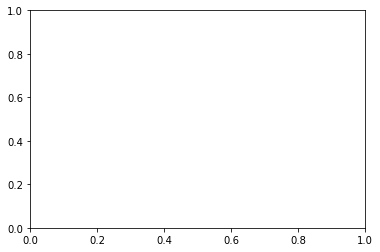

In [34]:

plt.plot(usv_spd,dif_sst,'.')
plt.xlabel('USV wind speed (ms$^{-1}$)')
plt.ylabel('USV - Sat SST (K)')
#sat_sst = ds_collocated_averaged.analysed_sst[:-19]-273.15
#usv_sst = ds_new.sst_usv[:-19]
#dif_sst = sat_sst - usv_sst
cond = usv_spd>2
dif_sst = dif_sst[cond] #.where(cond).dropna('time')
std_robust = np.nanmedian(dif_sst) * 1.482602218505602
print('no low wind mean,std,rstd, dif ',[dif_sst.mean().data,dif_sst.std().data,std_robust,sum(cond).data])

In [ ]:
plt.plot(usv_sst,dif_sst,'.')
plt.xlabel('USV  SST (K)')
plt.ylabel('USV - Sat SST (K)')

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.plt()


In [ ]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(sat_sst,sat_sst-usv_sst,'.')
ax.set_xlabel('USV wind speed (ms$^{-1}$)')
ax.set_ylabel('USV - Sat wind direction (deg)')
fig_fname='F:/data/cruise_data/saildrone/baja-2018/figs/sat_sst_both_bias.png'
fig.savefig(fig_fname, transparent=False, format='png')


In [ ]:
plt.plot(dif_sst[:-19],'.')

In [ ]:
subset.analysed_sst[0,:,:].plot()

In [ ]:
subset.analysed_sst.mean({'lat','lon'}).plot()

In [ ]:
subset.analysed_sst.mean({'time'}).plot()

In [ ]:
subset.analysed_sst.std({'time'}).plot()